In [75]:
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import trange
from math import e
from scipy.stats import beta
from scipy.spatial import distance
import argparse
import hashlib
import json
import wandb

def conf2tag(conf, n=8):
    """
    Creates unique tags for tracking experiments.
    """
    return hashlib.sha1(json.dumps(conf, sort_keys=True).encode("utf-8")).digest().hex()[:n]

def generate_optimum(nenvs, neffect):
    """
    Generates optimal expression patterns for different environments.
    Parameters:
        :int nenvs:         Number of different environments that can come up.
        :int neffect:       Number of effector genes, ie genes that matter in fitness function.
    Returns:
        List of optimal expression patterns.
    """
    envs = []
    if nenvs == 2:
        x = np.linspace(0,1,100)
        a, b = 2, 7
        y = beta.pdf(x, a, b) #using probability density function from scipy.stats
        y /= y.max()
        e=[]
        for i in range(neffect):
            t = y[int((100/neffect)*i)]
            t = np.around(t,2)
            e.append(t)
        envs.append(np.asarray(e))
        envs.append(np.asarray(e[::-1]))
    else:
        for env in range(nenvs):
            x = np.linspace(0,1,100)
            a, b = np.random.randint(low=1,high=30,size=1), np.random.randint(low=2,high=30,size=1)
            y = beta.pdf(x, a, b)
            y /= y.max()
            e=[]
            for i in range(neffect):
                t = y[int((100/neffect)*i)]
                t = np.around(t,2)
                e.append(t)
            envs.append(np.asarray(e))
    print("created envs")
    return(envs)


def fitness_function(grn_out,envs,state,args):
    #distance of GRN output to perfect expression in specific environmental state
    if np.sum(grn_out) != 0:
        grn_out = np.asarray(grn_out)

        diff = np.abs(grn_out - envs[state]).sum()
        f = 1-diff/args.E
    else:
        #print('not stable')
        f = 0

    return(f**3)

def calc_strategy(pop, ssize, envs, args):
    sample = np.random.choice(pop, ssize, replace=False)
    low = 0
    high = 0
    spec = 0
    gen = 0
    if args.nenv == 2:
        for p in sample:
            grn_out = p.grn_output()
            first_fitness = fitness_function(grn_out,envs,0,args)
            second_fitness = fitness_function(grn_out,envs,1,args)
            print(1,first_fitness)
            print(2,second_fitness)
            if (first_fitness < 0.3 and second_fitness < 0.3) or (0.3 <= first_fitness <= 0.7 and second_fitness < 0.3) or (first_fitness < 0.3 and 0.3 <=second_fitness <= 0.7):
                low += 1
            if (first_fitness > 0.7 and second_fitness > 0.7) or (0.3 <= first_fitness <= 0.7 and second_fitness > 0.7) or (first_fitness > 0.7 and 0.3 <=second_fitness <= 0.7):
                high += 1
            if (first_fitness < 0.3 and second_fitness > 0.7) or (first_fitness > 0.7 and second_fitness < 0.3):
                spec += 1
            if 0.3 <= first_fitness <= 0.7 and 0.3 <= second_fitness <= 0.7:
                gen += 1
                
            print("low",low)
            print("high", high)
            print("spec",spec)
            print("gen",gen)
            
    return(low, high,spec,gen)   
            

def calc_rob(pop, ssize, rounds, envs, state, args):
    ave_exp_rob = []
    ave_fit_rob = []
    ave_ben_mut = []
    ave_del_mut = []
    sample = np.random.choice(pop, ssize, replace=False)
    for p in sample:   
        exp_rob = 0
        fit_rob = 0
        ben_mut = 0
        del_mut = 0
        ori_grn_out = p.grn_output()
        ori_fitness = fitness_function(ori_grn_out,envs,state,args)
        for mut in range(rounds):
            sample_cp = deepcopy(p)
            sample_cp.mut_edge()
            new_grn_out = sample_cp.grn_output()
            new_fitness = fitness_function(new_grn_out,envs,state,args)
            if np.array_equal(ori_grn_out,new_grn_out):
                exp_rob += 1
                fit_rob += 1
            else:
                if new_fitness > ori_fitness:
                    ben_mut +=1
                elif new_fitness < ori_fitness:
                    del_mut += 1
                else:
                    fit_rob += 1
        if exp_rob > 0:
            ave_exp_rob.append(exp_rob/rounds)
        else:
            ave_exp_rob.append(exp_rob)
        if fit_rob > 0:
            ave_fit_rob.append(fit_rob/rounds)
        else:
            ave_fit_rob.append(fit_rob)
        if del_mut > 0:
            ave_del_mut.append(del_mut/(rounds - fit_rob))
        else:
            ave_del_mut.append(del_mut)
        if ben_mut > 0:
            ave_ben_mut.append(ben_mut/(rounds - fit_rob))
        else:
            ave_ben_mut.append(ben_mut)
    return(np.average(ave_exp_rob), np.average(ave_fit_rob), np.average(ave_ben_mut), np.average(ave_del_mut))
    

def create_pop(args):
    pop = []

    for i in range(args.pop_size):
        t = Agent(i+2, args)
        pop.append(t)

    print("created pop")
    return(pop)

class Agent:
    def __init__(self,ID,args):
        """
        Initialization of an individual.
        Parameters:
            :int ID:        Unique ID of the individual.
        Returns:
            None. Constructor method.
        """

        self.args = args #so that we can run experiments with various parameters

        #BUILDING INITIAL GRN
        N = self.args.E +1
        self.N = N #number of initial nodes, maternal + effectors
        self.nodes = list(np.arange(N))
        self.adjM = np.zeros((N, N))
        self.adjM[0,1:] = 0.1
        #initiate with maternal connected to effector genes
        self.adjM[0,0] = 1
        #and maternal positive feedbackloop (otherwise it turns itself down immediately and so the rest is also repressed)

        #OTHER PARAMETERS
        self.ID = ID
        self.tree = [] #ID and tree for building phylogenic trees
        self.alpha = 10 #for sigmoid function - could be mutated later, now constant
        self.blacklist = [] #set of deleted genes
        self.fitness = 0

        self.dn_rate = self.args.dn_rate
        self.dup_rate = self.args.dup_rate
        self.del_rate = self.args.del_rate
        self.edge_rate = self.args.edge_rate
        #these rates can later be under selection too


    def mutate(self):

        if random.uniform(0, 1) < self.dn_rate:
            self.add_dn_node()

        if random.uniform(0, 1) < self.dup_rate:
            self.add_dup_node()

        if random.uniform(0, 1) < self.del_rate:
            self.del_node()

        if random.uniform(0, 1) < self.edge_rate:
            self.mut_edge()

    def add_dn_node(self):
        #de novo gene, no interactions when initiated
        self.nodes.append(self.N)

        #Make adj matrix bigger
        column_to_be_added = np.zeros(self.N)
        self.adjM = np.column_stack((self.adjM, column_to_be_added))
        self.N += 1

        if self.N > 50:
            print("Number of nodes greater than 50!")

        row_to_be_added = np.zeros(self.N)
        self.adjM = np.vstack((self.adjM, row_to_be_added))

    def add_dup_node(self):
        #duplicate a node with all of its connections
        avail = list(set(self.nodes) - set(self.blacklist) - set(self.args.default_nodes))

        if len(avail) > 0:
            dup_node = np.random.choice(avail)

            column_to_be_added = self.adjM[:,dup_node] #duplicate column
            self.adjM = np.column_stack((self.adjM, column_to_be_added))

            row_to_be_added = self.adjM[dup_node,:] #duplicate row
            self.adjM = np.vstack((self.adjM, row_to_be_added))

            self.nodes.append(self.N)
            self.N += 1

            if self.N > 50:
                print("Number of nodes greater than 50!")

    def del_node(self):
        #delete an existing node with is not an effector or maternal gene
        #rows/columns in adj matrix are not deleted, all interactions are set to 0 instead
        #self.N incudes deleted nodes!
        avail = list(set(self.nodes) - set(self.blacklist) - set(self.args.default_nodes))

        if len(avail) > 0:

            deleted_node = np.random.choice(avail)

            self.adjM[deleted_node,:] = np.zeros(self.N)
            self.adjM[:,deleted_node] = np.zeros(self.N)

            self.blacklist.append(deleted_node)

    def mut_edge(self):
        #mutate the weight of an edge
        avail = list(set(self.nodes) - set(self.blacklist))

        mod_avail_from = list(set(avail) - set(self.args.effectors)) #effectors can't regulate
        from_nodes = np.random.choice(mod_avail_from)

        avail.remove(0) #maternal can't be regulated

        if from_nodes != 0: #otherwise I would remove 0 twice
            avail.remove(from_nodes) #self loops are not allowed

        to_nodes = np.random.choice(avail)

        self.adjM[from_nodes,to_nodes] = np.around(np.random.normal(0, 1, 1), 2)


    def sigm(self,sum_input):
    #adapted from wang 2014
        sum_input = sum_input-0.5
        x = sum_input * -self.alpha
        output = 1/(1 + np.exp(x))
        return output

    def grn_output(self, debug=False):
        a = self.adjM
        if debug:
            print(a)

        step = lambda a,s: self.sigm(s.dot(a)) #a step is matrix multiplication followed by checking on sigmodial function
        s = np.zeros(self.N)
        s[0] = 1 #starts with only maternal factor on
        e=0 #counter for state stability
        i=0 #counter for number of GRN updates
        ss=[] #stores GRN state for comparision to updated state

        while e < 2 and i < 3*(self.N-len(self.blacklist)):
            if debug:
                print(s) #print expression state
            ss.append(s) #only maternal ON at first
            s=step(a,s)
            s=np.around(s,2)
            s[s <=0.01] =0 #otherwise as sigm(0) is 0.01 deleted nodes wouldn't really be deleted
            s[s ==0.99] =1 #otherwise maternat impact is not constant but reducing
            if np.array_equal(ss[i], s):
                if i != 0:
                    e+=1
            i+=1

        if e > 1:
            conc_of_effectors = s[1:self.args.E+1]

        else:
            conc_of_effectors = np.linspace(0,0,self.args.E)
            conc_of_effectors = [int(i) for i in conc_of_effectors]
        return(conc_of_effectors)


def evolve(args):
    #gens = number of generations
    #season_length = number of generations before environment switches
    pop = create_pop(args)
    state = 0 # we start with environment 0
    envs = generate_optimum(args.nenv,args.E)

    average_fitness = [] #for tracking average fitness in pop per generation
    ave_grnsize = [] #average GRN size
    exp_rob= []
    fit_rob= []
    ben_mut= []
    del_mut= []
    low=[]
    high=[]
    spec=[]
    gen=[]

    for i in trange(args.gens):
        #every generation
        #check fitness and generate based on that new population

        grn_size=[]

        for idx, ind in enumerate(pop): #mutate and change ID
            ind.mutate()
            if i > 0:
                ind.ID = 2+(args.pop_size*i)+idx
            ind.tree.append(ind.ID)
            grn_size.append(ind.N-len(ind.blacklist))

        ave_grnsize.append(np.average(grn_size))
        wandb.log({'average_grnsize': np.average(grn_size)}, commit=False)
        
        ssize = 1#int(args.pop_size/10)
        rounds = 50
        ave_exp_rob, ave_fit_rob, ave_ben_mut, ave_del_mut=calc_rob(pop, ssize, rounds, envs, state, args)
        exp_rob.append(ave_exp_rob)
        fit_rob.append(ave_fit_rob)
        ben_mut.append(ave_ben_mut)
        del_mut.append(ave_del_mut)
        
        lowt, hight,spect,gent = calc_strategy(pop, ssize, envs, args)
        low.append(lowt)
        high.append(hight)
        spec.append(spect)
        gen.append(gent)

        for p in pop:
            grn_out = p.grn_output()
            p.fitness = fitness_function(grn_out,envs,state,args) #will depend on env
            cost_of_nodes = (p.N-len(p.blacklist)-(args.E+1))*args.node_cost
            if cost_of_nodes <= p.fitness:
                p.fitness = p.fitness - cost_of_nodes

        pop_fitness = [x.fitness for x in pop]
        tot_fitness = np.sum(pop_fitness)
        average_fitness.append(np.mean(pop_fitness))
        wandb.log({'average_fitness': np.mean(pop_fitness)}, commit=False)

        pop_prob = [f/tot_fitness for f in pop_fitness]
        new_pop = np.random.choice(pop, args.pop_size, p=pop_prob, replace = True) #same individual can be selected over and over again
        pop = [deepcopy(agent) for agent in new_pop]
        


        rd = (i+1) % args.season_length

        if rd == 0:
            #print("after this changed state")
            if state == 0:
                state = 1 #np.random.choice(nenvs)
            else:
                state = 0

    best_agent = max([{"fitness" : x.fitness, "Agent" : x.adjM} for x in pop], key=lambda x : x["fitness"])["Agent"]

    return(pop, average_fitness, ave_grnsize, exp_rob, fit_rob, ben_mut, del_mut, best_agent, high,low,spec,gen)




In [76]:
if __name__ == "__main__":
    # Here the stuff you want to execute with python main.py


    parser = argparse.ArgumentParser(description='Process some integers.')

    parser.add_argument('-E', type=int, default=4, help="Number of effector genes")

    #number of environments that fluctuate, IMPORTANT VARIABLE
    parser.add_argument('-nenv', type=int, default=2, help="Number of environments")

    #arbitrary mutation rates
    #we could also make these rates evolve themselves
    parser.add_argument('-dn_rate', type=float, default=0.005, help="De novo Mutation rate")
    parser.add_argument('-dup_rate', type=float, default=0.005, help="Dup Mutation rate")
    parser.add_argument('-del_rate', type=float, default=0.01, help="Del Mutation rate")
    parser.add_argument('-edge_rate', type=float, default=0.8, help="Edge Mutation rate")
    
    parser.add_argument('-node_cost', type=float, default=0.01, help="Cost of having a node")

    parser.add_argument('-pop_size', type=int, default=100, help="Population size")
    parser.add_argument('-gens', type=int, default=1000, help="Number of generations")
    parser.add_argument('-season_length', type=int, default=10000, help="Number of generations in an env")
    parser.add_argument('-exp_type', type=str, default="ANONYMUS", help="Name your experiment for grouping")
    parser.add_argument('-rep', type=str, default="1", help="ID of replicate")

    args = parser.parse_args("")

    tag = conf2tag(vars(args))
    wandb.init(project="test-project-11132020", group=args.exp_type+tag)

    ### Important variables to set

    args.default_nodes = np.linspace(0,args.E,args.E+1)
    args.default_nodes = [int(i) for i in args.default_nodes] #maternal factor and E effector genes, can't be duplicated or removed
    args.effectors = np.delete(args.default_nodes, 0) #effector genes don't have outgoing edges, only incoming
    args.name_of_file = args.exp_type + tag + "_" + args.rep
    print(args.name_of_file)


    ### RUN CODE
    print("running code")
    pop, average_fitness, ave_grnsize, exp_rob, fit_rob, ben_mut, del_mut, best_agent, high,low,spec,gen = evolve(args)

  0%|          | 1/1000 [00:00<02:55,  5.69it/s]

ANONYMUSef1bc3fd_1
running code
created pop
created envs
1 0.47455200000000003
2 0.5513679999999999
low 0
high 0
spec 0
gen 1


  0%|          | 3/1000 [00:00<02:24,  6.91it/s]

1 0.14678017187499998
2 0.14678017187499998
low 1
high 0
spec 0
gen 0
1 0.45210067187500014
2 0.45210067187500014
low 0
high 0
spec 0
gen 1
1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0


  1%|          | 6/1000 [00:00<02:03,  8.02it/s]

1 0.46099420312499995
2 0.46099420312499995
low 0
high 0
spec 0
gen 1
1 0.681472
2 0.17095387499999995
low 1
high 0
spec 0
gen 0


  1%|          | 7/1000 [00:00<02:10,  7.59it/s]

1 0.747377296875
2 0.19764589062500001
low 0
high 0
spec 1
gen 0
1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0


  1%|          | 10/1000 [00:01<02:15,  7.29it/s]

1 0.7049690000000001
2 0.18036212499999996
low 0
high 0
spec 1
gen 0
1 0.8043569999999999
2 0.221445125
low 0
high 0
spec 1
gen 0


  1%|          | 12/1000 [00:01<02:17,  7.17it/s]

1 0.5821828749999999
2 0.13265100000000002
low 1
high 0
spec 0
gen 0
1 0.44332226562499993
2 0.44332226562499993
low 0
high 0
spec 0
gen 1


  1%|▏         | 13/1000 [00:01<02:40,  6.17it/s]

1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0


  2%|▏         | 15/1000 [00:02<02:38,  6.23it/s]

1 0.8709838749999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0


  2%|▏         | 17/1000 [00:02<02:37,  6.26it/s]

1 0
2 0
low 1
high 0
spec 0
gen 0
1 0.497734578125
2 0.497734578125
low 0
high 0
spec 0
gen 1


  2%|▏         | 19/1000 [00:02<02:13,  7.36it/s]

1 0.6141249999999999
2 0.5120000000000001
low 0
high 0
spec 0
gen 1
1 0.46548437500000006
2 0.09112499999999997
low 1
high 0
spec 0
gen 0
1 0.747377296875
2 0.19764589062500001
low 0
high 0
spec 1
gen 0


  2%|▏         | 21/1000 [00:02<02:06,  7.77it/s]

1 0.47000360937499996
2 0.47000360937499996
low 0
high 0
spec 0
gen 1
1 0.778688
2 0.21064487499999998
low 0
high 0
spec 1
gen 0
1 0.244140625
2 0.121287375
low 1
high 0
spec 0
gen 0


  2%|▏         | 24/1000 [00:03<01:55,  8.47it/s]

1 0.797887671875
2 0.21871126562500004
low 0
high 0
spec 1
gen 0
1 0.8174003750000002
2 0.226981
low 0
high 0
spec 1
gen 0
1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0


  3%|▎         | 27/1000 [00:03<02:07,  7.61it/s]

1 0.3850339218750001
2 0.3850339218750001
low 0
high 0
spec 0
gen 1
1 0.47912964062499996
2 0.09575760937500001
low 1
high 0
spec 0
gen 0


  3%|▎         | 30/1000 [00:03<01:59,  8.10it/s]

1 0.39302745312500004
2 0.39302745312500004
low 0
high 0
spec 0
gen 1
1 0.747377296875
2 0.19764589062500001
low 0
high 0
spec 1
gen 0


  3%|▎         | 31/1000 [00:04<02:16,  7.11it/s]

1 0.7350918906249999
2 0.19764589062500001
low 0
high 0
spec 1
gen 0
1 0
2 0
low 1
high 0
spec 0
gen 0


  3%|▎         | 33/1000 [00:04<02:16,  7.07it/s]

1 0.3771495156249999
2 0.516815015625
low 0
high 0
spec 0
gen 1
1 0.8986321249999999
2 0.26214400000000004
low 0
high 0
spec 1
gen 0
1 0.44332226562499993
2 0.083740234375
low 1
high 0
spec 0
gen 0


  4%|▎         | 36/1000 [00:04<02:14,  7.17it/s]

1 0.456533
2 0.456533
low 0
high 0
spec 0
gen 1


  4%|▍         | 38/1000 [00:05<02:14,  7.15it/s]

1 0.49303900000000006
2 0.49303900000000006
low 0
high 0
spec 0
gen 1
1 0.7412176250000001
2 0.19511199999999995
low 0
high 0
spec 1
gen 0


  4%|▍         | 39/1000 [00:05<02:50,  5.65it/s]

1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0
1 0.7723572343749999
2 0.20800082812500004
low 0
high 0
spec 1
gen 0


  4%|▍         | 42/1000 [00:05<02:11,  7.30it/s]

1 0.5120000000000001
2 0.531441
low 0
high 0
spec 0
gen 1
1 0.47455200000000003
2 0.47455200000000003
low 0
high 0
spec 0
gen 1


  4%|▍         | 44/1000 [00:05<02:15,  7.04it/s]

1 0.810861203125
2 0.22420167187499992
low 0
high 0
spec 1
gen 0
1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0


  4%|▍         | 45/1000 [00:06<02:33,  6.23it/s]

1 0.797887671875
2 0.21871126562500004
low 0
high 0
spec 1
gen 0
1 0.310976734375
2 0.04380032812500001
low 1
high 0
spec 0
gen 0


  5%|▍         | 47/1000 [00:06<02:40,  5.93it/s]

1 0.7723572343749999
2 0.20800082812500004
low 0
high 0
spec 1
gen 0
1 0.7914531250000001
2 0.21599999999999997
low 0
high 0
spec 1
gen 0


  5%|▍         | 49/1000 [00:06<03:03,  5.17it/s]

1 0.747377296875
2 0.19764589062500001
low 0
high 0
spec 1
gen 0
1 0.669921875
2 0.46548437500000006
low 0
high 0
spec 0
gen 1


  5%|▌         | 52/1000 [00:07<02:29,  6.33it/s]

1 0.6872965156250002
2 0.1732744843750001
low 1
high 0
spec 0
gen 0
1 0.9556716249999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


  5%|▌         | 54/1000 [00:07<02:18,  6.85it/s]

1 0.25604787500000004
2 0.10717187499999999
low 1
high 0
spec 0
gen 0
1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0


  6%|▌         | 56/1000 [00:07<02:13,  7.08it/s]

1 0.15966114062499998
2 0.18276692187500002
low 1
high 0
spec 0
gen 0
1 0.5717869999999999
2 0.5717869999999999
low 0
high 0
spec 0
gen 1


  6%|▌         | 58/1000 [00:08<01:57,  7.99it/s]

1 0.40934489062500007
2 0.40934489062500007
low 0
high 0
spec 0
gen 1
1 0.3579109999999999
2 0.06400000000000002
low 1
high 0
spec 0
gen 0


  6%|▌         | 60/1000 [00:08<01:49,  8.57it/s]

1 0.15528710937499998
2 0.15528710937499998
low 1
high 0
spec 0
gen 0
1 0.3504026250000001
2 0.38901699999999995
low 0
high 0
spec 0
gen 1
1

  6%|▌         | 62/1000 [00:08<01:53,  8.26it/s]

 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.47455200000000003
2 0.47455200000000003
low 0
high 0
spec 0
gen 1


  6%|▋         | 63/1000 [00:08<02:33,  6.12it/s]

1 0.317912765625
2 0.04569073437499997
low 1
high 0
spec 0
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


  7%|▋         | 66/1000 [00:09<02:03,  7.54it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.40934489062500007
2 0.40934489062500007
low 0
high 0
spec 0
gen 1
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


  7%|▋         | 69/1000 [00:09<01:46,  8.74it/s]

1 0.823974609375
2 0.22978320312500006
low 0
high 0
spec 1
gen 0
1 0.44769712500000003
2 0.44769712500000003
low 0
high 0
spec 0
gen 1
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


  7%|▋         | 72/1000 [00:09<01:42,  9.04it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.7169173750000001
2 0.281011375
low 0
high 0
spec 1
gen 0


  7%|▋         | 73/1000 [00:09<01:52,  8.23it/s]

1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0
1 0.3579109999999999
2 0.06400000000000002
low 1
high 0
spec 0
gen 0


  8%|▊         | 75/1000 [00:10<02:18,  6.70it/s]

1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0
1 0.507214984375
2 0.11585742187500003
low 1
high 0
spec 0
gen 0


  8%|▊         | 77/1000 [00:10<02:19,  6.60it/s]

1 0.177978515625
2 0.6990449218749999
low 1
high 0
spec 0
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


  8%|▊         | 80/1000 [00:11<02:16,  6.72it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.8986321249999999
2 0.281011375
low 0
high 0
spec 1
gen 0


  8%|▊         | 82/1000 [00:11<01:59,  7.70it/s]

1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


  8%|▊         | 83/1000 [00:11<02:22,  6.43it/s]

1 0.9268593749999999
2 0.3429999999999999
low 0
high 1
spec 0
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


  9%|▊         | 86/1000 [00:11<02:04,  7.35it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


  9%|▊         | 87/1000 [00:12<01:58,  7.72it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0


  9%|▉         | 90/1000 [00:12<02:06,  7.17it/s]

1 0.5717869999999999
2 0.47455200000000003
low 0
high 0
spec 0
gen 1
1 0.11232901562499994
2 0.19764589062500001
low 1
high 0
spec 0
gen 0


  9%|▉         | 91/1000 [00:12<02:09,  7.02it/s]

1 0.497734578125
2 0.11232901562499994
low 1
high 0
spec 0
gen 0
1 0.6990449218749999
2 0.324951171875
low 0
high 0
spec 0
gen 1


  9%|▉         | 94/1000 [00:13<02:05,  7.22it/s]

1 0.797887671875
2 0.21871126562500004
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 10%|▉         | 96/1000 [00:13<01:52,  8.01it/s]

1 0.9268593749999999
2 0.29407962500000007
low 0
high 0
spec 1
gen 0
1 0.810861203125
2 0.22420167187500004
low 0
high 0
spec 1
gen 0


 10%|▉         | 97/1000 [00:13<01:57,  7.69it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.7914531250000001
2 0.26214400000000004
low 0
high 0
spec 1
gen 0


 10%|█         | 100/1000 [00:13<02:02,  7.33it/s]

1 0.7350918906249999
2 0.19259985937500002
low 0
high 0
spec 1
gen 0
1 0
2 0
low 1
high 0
spec 0
gen 0


 10%|█         | 101/1000 [00:13<01:58,  7.59it/s]

1 0.7049690000000001
2 0.38901699999999995
low 0
high 1
spec 0
gen 0
1 0.636056
2 0.456533
low 0
high 0
spec 0
gen 1


 10%|█         | 103/1000 [00:14<04:00,  3.72it/s]

1 0.6990449218749999
2 0.324951171875
low 0
high 0
spec 0
gen 1
1 0.7350918906249999
2 0.35414354687500005
low 0
high 1
spec 0
gen 0
1 0.8043569999999999
2 0.221445125
low 0
high 0
spec 1
gen 0


 11%|█         | 107/1000 [00:15<02:40,  5.57it/s]

1 0.8439086250000002
2 0.23832799999999998
low 0
high 0
spec 1
gen 0
1 0.810861203125
2 0.22420167187500004
low 0
high 0
spec 1
gen 0


 11%|█         | 108/1000 [00:15<02:55,  5.08it/s]

1 0.8986321249999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.6472146249999999
2 0.5216601249999999
low 0
high 0
spec 0
gen 1


 11%|█         | 111/1000 [00:15<02:15,  6.56it/s]

1 0.9629667968750001
2 0.310976734375
low 0
high 1
spec 0
gen 0
1 0.837228640625
2 0.23545660937499993
low 0
high 0
spec 1
gen 0


 11%|█▏        | 113/1000 [00:16<02:06,  7.01it/s]

1 0.075418890625
2 0.075418890625
low 1
high 0
spec 0
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 11%|█▏        | 114/1000 [00:16<02:21,  6.25it/s]

1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0
1 0.8986321249999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0


 12%|█▏        | 116/1000 [00:16<02:52,  5.11it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 12%|█▏        | 117/1000 [00:17<02:51,  5.15it/s]

1 0.5024598749999999
2 0.531441
low 0
high 0
spec 0
gen 1
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 12%|█▏        | 120/1000 [00:17<02:19,  6.32it/s]

1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0
1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0


 12%|█▏        | 121/1000 [00:17<02:20,  6.25it/s]

1 0.7290000000000001
2 0.19010937499999997
low 0
high 0
spec 1
gen 0


 12%|█▏        | 122/1000 [00:17<02:45,  5.31it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.46548437500000006
2 0.49303900000000006
low 0
high 0
spec 0
gen 1


 12%|█▏        | 124/1000 [00:18<02:35,  5.63it/s]

1 0.8305839999999999
2 0.250047
low 0
high 0
spec 1
gen 0
1 0.497734578125
2 0.497734578125
low 0
high 0
spec 0
gen 1


 13%|█▎        | 126/1000 [00:18<02:33,  5.69it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 13%|█▎        | 128/1000 [00:18<02:24,  6.04it/s]

1 0.456533
2 0.5927039999999999
low 0
high 0
spec 0
gen 1
1 0.5513680000000001
2 0.5513680000000001
low 0
high 0
spec 0
gen 1


 13%|█▎        | 130/1000 [00:19<02:01,  7.19it/s]

1 0.7535710000000001
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.797887671875
2 0.21871126562500004
low 0
high 0
spec 1
gen 0


 13%|█▎        | 131/1000 [00:19<02:07,  6.81it/s]

1 0.430368875
2 0.08812112500000004
low 1
high 0
spec 0
gen 0


 13%|█▎        | 132/1000 [00:19<02:19,  6.21it/s]

1 0.47455200000000003
2 0.47455200000000003
low 0
high 0
spec 0
gen 1
1 0.8305839999999999
2 0.250047
low 0
high 0
spec 1
gen 0


 14%|█▎        | 135/1000 [00:19<01:59,  7.23it/s]

1 0.837228640625
2 0.23545660937499993
low 0
high 0
spec 1
gen 0
1 0.6641960781250001
2 0.177978515625
low 1
high 0
spec 0
gen 0


 14%|█▎        | 136/1000 [00:20<02:04,  6.94it/s]

1 0.837228640625
2 0.23545660937499993
low 0
high 0
spec 1
gen 0
1 0.546340359375
2 0.546340359375
low 0
high 0
spec 0
gen 1


 14%|█▍        | 139/1000 [00:20<01:57,  7.34it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 14%|█▍        | 140/1000 [00:20<01:53,  7.54it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8043569999999999
2 0.221445125
low 0
high 0
spec 1
gen 0


 14%|█▍        | 143/1000 [00:21<02:09,  6.63it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.797887671875
2 0.21871126562500004
low 0
high 0
spec 1
gen 0


 14%|█▍        | 144/1000 [00:21<02:06,  6.76it/s]

1 0.8305839999999999
2 0.250047
low 0
high 0
spec 1
gen 0
1 0.785053265625
2 0.21331123437500002
low 0
high 0
spec 1
gen 0


 15%|█▍        | 146/1000 [00:21<02:17,  6.23it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0
2 0
low 1
high 0
spec 0
gen 0


 15%|█▍        | 149/1000 [00:22<02:20,  6.06it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 15%|█▌        | 151/1000 [00:22<02:04,  6.80it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.778688
2 0.226981
low 0
high 0
spec 1
gen 0


 15%|█▌        | 153/1000 [00:22<01:55,  7.33it/s]

1 0.970299
2 0.3214191250000001
low 0
high 1
spec 0
gen 0
1 0.891666015625
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 16%|█▌        | 155/1000 [00:22<01:58,  7.15it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 16%|█▌        | 156/1000 [00:23<01:55,  7.32it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 16%|█▌        | 159/1000 [00:23<02:03,  6.78it/s]

1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 16%|█▌        | 160/1000 [00:23<02:00,  6.97it/s]

1 0.3850339218750001
2 0.07277285937499998
low 1
high 0
spec 0
gen 0


 16%|█▌        | 161/1000 [00:24<02:31,  5.54it/s]

1 0.6990449218749999
2 0.48837304687499994
low 0
high 0
spec 0
gen 1
1 0.3579109999999999
2 0.06399999999999996
low 1
high 0
spec 0
gen 0


 16%|█▋        | 163/1000 [00:24<02:13,  6.26it/s]

1 0.413493625
2 0.413493625
low 0
high 0
spec 0
gen 1
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 17%|█▋        | 166/1000 [00:24<02:03,  6.73it/s]

1 0.507214984375
2 0.507214984375
low 0
high 0
spec 0
gen 1
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 17%|█▋        | 168/1000 [00:24<01:57,  7.10it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 17%|█▋        | 169/1000 [00:25<01:55,  7.18it/s]

1 0.9056344218750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0
1 0.48373662500000003
2 0.48373662500000003
low 0
high 0
spec 0
gen 1


 17%|█▋        | 171/1000 [00:25<02:15,  6.14it/s]

1 0.8847359999999999
2 0.25604787500000004
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 17%|█▋        | 173/1000 [00:25<02:06,  6.54it/s]

1 0.891666015625
2 0.25908398437499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 18%|█▊        | 176/1000 [00:26<01:49,  7.50it/s]

1 0.6087221718750001
2 0.566635796875
low 0
high 0
spec 0
gen 1
1 0.8573749999999999
2 0.28749600000000003
low 0
high 0
spec 1
gen 0


 18%|█▊        | 178/1000 [00:26<01:44,  7.89it/s]

1 0
2 0
low 1
high 0
spec 0
gen 0
1 0.864161578125
2 0.2652280156249999
low 0
high 0
spec 1
gen 0


 18%|█▊        | 179/1000 [00:26<01:44,  7.85it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 18%|█▊        | 181/1000 [00:26<01:54,  7.15it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 18%|█▊        | 184/1000 [00:27<01:45,  7.70it/s]

1 0.48373662499999986
2 0.48373662499999986
low 0
high 0
spec 0
gen 1
1 0.850624046875
2 0.24122264062500007
low 0
high 0
spec 1
gen 0


 19%|█▊        | 186/1000 [00:27<01:41,  8.00it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8986321249999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 19%|█▉        | 188/1000 [00:27<01:44,  7.74it/s]

1 0.8986321249999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.850624046875
2 0.24122264062500007
low 0
high 0
spec 1
gen 0


 19%|█▉        | 190/1000 [00:27<01:46,  7.57it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 19%|█▉        | 192/1000 [00:28<01:46,  7.61it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 19%|█▉        | 194/1000 [00:28<01:46,  7.60it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.310976734375
2 0.04380032812500001
low 1
high 0
spec 0
gen 0


 20%|█▉        | 195/1000 [00:28<01:45,  7.65it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.864161578125
2 0.37714951562500004
low 0
high 1
spec 0
gen 0


 20%|█▉        | 198/1000 [00:29<01:45,  7.58it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.864161578125
2 0.37714951562500004
low 0
high 1
spec 0
gen 0


 20%|██        | 200/1000 [00:29<01:44,  7.66it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8573749999999999
2 0.381078125
low 0
high 1
spec 0
gen 0


 20%|██        | 202/1000 [00:29<01:40,  7.98it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 20%|██        | 203/1000 [00:29<01:41,  7.87it/s]

1 0.7169173750000001
2 0.18519299999999994
low 0
high 0
spec 1
gen 0
1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0


 21%|██        | 206/1000 [00:30<01:45,  7.51it/s]

1 0.864161578125
2 0.37714951562500004
low 0
high 1
spec 0
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 21%|██        | 208/1000 [00:30<01:43,  7.65it/s]

1 0.7914531250000001
2 0.21599999999999997
low 0
high 0
spec 1
gen 0
1 0.912673
2 0.26833612500000004
low 0
high 0
spec 1
gen 0


 21%|██        | 210/1000 [00:30<01:45,  7.50it/s]

1 0.970299
2 0.3214191250000001
low 0
high 1
spec 0
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 21%|██        | 211/1000 [00:30<01:47,  7.33it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 21%|██▏       | 214/1000 [00:31<01:46,  7.37it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.7786879999999998
2 0.32850899999999994
low 0
high 1
spec 0
gen 0


 22%|██▏       | 216/1000 [00:31<01:44,  7.53it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.7786879999999998
2 0.430368875
low 0
high 1
spec 0
gen 0


 22%|██▏       | 218/1000 [00:31<01:40,  7.76it/s]

1 0.8847359999999999
2 0.25604787500000004
low 0
high 0
spec 1
gen 0
1 0.8439086249999999
2 0.25604787500000004
low 0
high 0
spec 1
gen 0


 22%|██▏       | 219/1000 [00:31<01:48,  7.20it/s]

1 0.7786879999999998
2 0.430368875
low 0
high 1
spec 0
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 22%|██▏       | 222/1000 [00:32<01:43,  7.55it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 22%|██▏       | 224/1000 [00:32<01:41,  7.67it/s]

1 0.9411919999999999
2 0.3007629999999999
low 0
high 1
spec 0
gen 0
1 0.49303900000000006
2 0.49303900000000006
low 0
high 0
spec 0
gen 1


 22%|██▎       | 225/1000 [00:32<01:46,  7.28it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9411919999999999
2 0.3007629999999999
low 0
high 1
spec 0
gen 0


 23%|██▎       | 228/1000 [00:33<01:44,  7.42it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.7169173750000001
2 0.47455200000000003
low 0
high 1
spec 0
gen 0


 23%|██▎       | 229/1000 [00:33<01:44,  7.39it/s]

1 0.250047
2 0.140608
low 1
high 0
spec 0
gen 0
1 0.23260837499999998
2 0.12878762500000002
low 1
high 0
spec 0
gen 0


 23%|██▎       | 232/1000 [00:33<01:53,  6.77it/s]

1 0.7412176250000001
2 0.19511199999999995
low 0
high 0
spec 1
gen 0
1 0.430368875
2 0.08812112499999997
low 1
high 0
spec 0
gen 0


 23%|██▎       | 233/1000 [00:33<01:55,  6.67it/s]

1 0.3771495156249999
2 0.070189453125
low 1
high 0
spec 0
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 24%|██▎       | 236/1000 [00:34<01:44,  7.34it/s]

1 0.9556716249999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 24%|██▎       | 237/1000 [00:34<01:44,  7.27it/s]

1 0.38901699999999995
2 0.07408799999999996
low 1
high 0
spec 0
gen 0
1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0


 24%|██▍       | 239/1000 [00:34<01:44,  7.31it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.2652280156250001
low 0
high 0
spec 1
gen 0


 24%|██▍       | 241/1000 [00:34<01:50,  6.88it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 24%|██▍       | 243/1000 [00:35<01:49,  6.90it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 24%|██▍       | 245/1000 [00:35<01:46,  7.09it/s]

1 0.9268593749999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 25%|██▍       | 247/1000 [00:35<01:51,  6.73it/s]

1 0.9268593749999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 25%|██▍       | 249/1000 [00:36<01:48,  6.90it/s]

1 0.970299
2 0.29407962500000007
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 25%|██▌       | 251/1000 [00:36<01:46,  7.04it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 25%|██▌       | 253/1000 [00:36<01:47,  6.98it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 26%|██▌       | 255/1000 [00:36<01:52,  6.60it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.8439086250000002
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 26%|██▌       | 257/1000 [00:37<02:02,  6.06it/s]

1 0.9197479531250001
2 0.271468421875
low 0
high 0
spec 1
gen 0


 26%|██▌       | 258/1000 [00:37<02:11,  5.63it/s]

1 0.7535710000000001
2 0.21599999999999997
low 0
high 0
spec 1
gen 0
1 0.8439086250000002
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 26%|██▌       | 260/1000 [00:37<02:30,  4.93it/s]

1 0.8439086250000002
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 26%|██▌       | 261/1000 [00:38<02:32,  4.85it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 26%|██▋       | 263/1000 [00:38<02:20,  5.25it/s]

1 0.8439086250000002
2 0.30754687500000005
low 0
high 1
spec 0
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 26%|██▋       | 265/1000 [00:38<02:08,  5.72it/s]

1 0.9268593749999999
2 0.28749600000000003
low 0
high 0
spec 1
gen 0
1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 27%|██▋       | 267/1000 [00:39<01:58,  6.18it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.877841984375
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 27%|██▋       | 269/1000 [00:39<02:03,  5.90it/s]

1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 27%|██▋       | 271/1000 [00:39<02:03,  5.92it/s]

1 0.9411919999999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 27%|██▋       | 272/1000 [00:40<02:09,  5.63it/s]

1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0
1 0.405224
2 0.10382299999999998
low 1
high 0
spec 0
gen 0


 28%|██▊       | 275/1000 [00:40<01:51,  6.47it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 28%|██▊       | 276/1000 [00:40<01:52,  6.46it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 28%|██▊       | 278/1000 [00:40<01:57,  6.16it/s]

1 0.9268593749999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 28%|██▊       | 280/1000 [00:41<01:51,  6.48it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.9484133906250001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 28%|██▊       | 282/1000 [00:41<01:52,  6.36it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 28%|██▊       | 284/1000 [00:41<01:56,  6.16it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.9268593749999999
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 29%|██▊       | 286/1000 [00:42<01:50,  6.44it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 29%|██▉       | 288/1000 [00:42<01:44,  6.80it/s]

1 0.7229418593749999
2 0.4261078281249999
low 0
high 1
spec 0
gen 0
1 0.9340073593750001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 29%|██▉       | 290/1000 [00:42<01:43,  6.85it/s]

1 0.864161578125
2 0.35414354687500005
low 0
high 1
spec 0
gen 0
1 0.7914531250000001
2 0.21599999999999997
low 0
high 0
spec 1
gen 0


 29%|██▉       | 292/1000 [00:43<01:39,  7.11it/s]

1 0.864161578125
2 0.35414354687500005
low 0
high 1
spec 0
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 30%|██▉       | 295/1000 [00:43<01:32,  7.66it/s]

1 0.8847359999999999
2 0.25604787500000004
low 0
high 0
spec 1
gen 0
1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 30%|██▉       | 296/1000 [00:43<01:31,  7.74it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.20277929687500001
2 0.759798828125
low 0
high 0
spec 1
gen 0


 30%|██▉       | 298/1000 [00:43<01:35,  7.36it/s]

1 0.9268593749999999
2 0.2874959999999999
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 30%|███       | 301/1000 [00:44<01:34,  7.36it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0
1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 30%|███       | 303/1000 [00:44<01:31,  7.66it/s]

1 0.9925187343750002
2 0.310976734375
low 0
high 1
spec 0
gen 0
1 0.7914531250000001
2 0.21599999999999997
low 0
high 0
spec 1
gen 0


 30%|███       | 304/1000 [00:44<01:33,  7.41it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.785053265625
2 0.22420167187499992
low 0
high 0
spec 1
gen 0


 31%|███       | 306/1000 [00:44<01:38,  7.04it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.912673
2 0.26833612500000004
low 0
high 0
spec 1
gen 0


 31%|███       | 308/1000 [00:45<01:41,  6.81it/s]

1 0.8573749999999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 31%|███       | 310/1000 [00:45<01:44,  6.63it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.8174003750000002
2 0.32850899999999994
low 0
high 1
spec 0
gen 0


 31%|███       | 312/1000 [00:45<01:47,  6.37it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 31%|███▏      | 314/1000 [00:46<01:42,  6.70it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.9484133906250001
2 0.332092703125
low 0
high 1
spec 0
gen 0


 32%|███▏      | 316/1000 [00:46<01:43,  6.61it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 32%|███▏      | 318/1000 [00:46<01:52,  6.08it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 32%|███▏      | 319/1000 [00:47<01:57,  5.77it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.912673
2 0.26833612500000004
low 0
high 0
spec 1
gen 0


 32%|███▏      | 321/1000 [00:47<01:49,  6.20it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.2652280156249999
low 0
high 0
spec 1
gen 0


 32%|███▏      | 323/1000 [00:47<01:48,  6.23it/s]

1 0.877841984375
2 0.271468421875
low 0
high 0
spec 1
gen 0
1 0.9484133906250001
2 0.332092703125
low 0
high 1
spec 0
gen 0


 32%|███▎      | 325/1000 [00:47<01:46,  6.34it/s]

1 0.9056344218750001
2 0.2652280156249999
low 0
high 0
spec 1
gen 0
1 0.7350918906249999
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 33%|███▎      | 327/1000 [00:48<01:41,  6.62it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 33%|███▎      | 329/1000 [00:48<01:49,  6.12it/s]

1 0.9197479531250001
2 0.317912765625
low 0
high 1
spec 0
gen 0
1 0.985074875
2 0.31443199999999993
low 0
high 1
spec 0
gen 0


 33%|███▎      | 331/1000 [00:48<01:50,  6.05it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 33%|███▎      | 332/1000 [00:49<01:58,  5.62it/s]

1 0.9484133906250001
2 0.332092703125
low 0
high 1
spec 0
gen 0
1 0.8986321249999999
2 0.26214400000000004
low 0
high 0
spec 1
gen 0


 33%|███▎      | 334/1000 [00:49<01:47,  6.22it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.8986321249999999
2 0.26214400000000004
low 0
high 0
spec 1
gen 0


 34%|███▎      | 336/1000 [00:49<01:39,  6.67it/s]

1 0.9484133906250001
2 0.332092703125
low 0
high 1
spec 0
gen 0
1 0.985074875
2 0.31443199999999993
low 0
high 1
spec 0
gen 0


 34%|███▍      | 338/1000 [00:50<01:42,  6.45it/s]

1 0.985074875
2 0.31443199999999993
low 0
high 1
spec 0
gen 0
1 0.8986321249999999
2 0.26214400000000004
low 0
high 0
spec 1
gen 0


 34%|███▍      | 340/1000 [00:50<01:39,  6.64it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 34%|███▍      | 342/1000 [00:50<01:39,  6.58it/s]

1 0.9268593749999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.985074875
2 0.31443199999999993
low 0
high 1
spec 0
gen 0


 34%|███▍      | 344/1000 [00:50<01:45,  6.21it/s]

1 0.9484133906250001
2 0.332092703125
low 0
high 1
spec 0
gen 0
1 0.9484133906250001
2 0.332092703125
low 0
high 1
spec 0
gen 0


 35%|███▍      | 346/1000 [00:51<01:40,  6.49it/s]

1 0.985074875
2 0.31443199999999993
low 0
high 1
spec 0
gen 0
1 0.823974609375
2 0.24122264062500007
low 0
high 0
spec 1
gen 0


 35%|███▍      | 348/1000 [00:51<01:40,  6.50it/s]

1 0.8439086249999999
2 0.32850899999999994
low 0
high 1
spec 0
gen 0
1 0.823974609375
2 0.24122264062500007
low 0
high 0
spec 1
gen 0


 35%|███▌      | 350/1000 [00:51<01:49,  5.95it/s]

1 0.9484133906250001
2 0.332092703125
low 0
high 1
spec 0
gen 0


 35%|███▌      | 351/1000 [00:52<01:58,  5.46it/s]

1 0.9056344218750001
2 0.2652280156249999
low 0
high 0
spec 1
gen 0
1 0.985074875
2 0.31443199999999993
low 0
high 1
spec 0
gen 0


 35%|███▌      | 353/1000 [00:52<02:13,  4.84it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 35%|███▌      | 354/1000 [00:52<02:13,  4.85it/s]

1 0.8439086249999999
2 0.32850899999999994
low 0
high 1
spec 0
gen 0


 36%|███▌      | 355/1000 [00:52<02:08,  5.02it/s]

1 0.8986321249999999
2 0.26214400000000004
low 0
high 0
spec 1
gen 0


 36%|███▌      | 356/1000 [00:53<02:16,  4.71it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.36937348437500006
2 0.06046707812499998
low 1
high 0
spec 0
gen 0


 36%|███▌      | 358/1000 [00:53<02:15,  4.73it/s]

1 0.970299
2 0.3214191250000001
low 0
high 1
spec 0
gen 0


 36%|███▌      | 359/1000 [00:53<02:06,  5.07it/s]

1 0.5821828749999999
2 0.5927039999999999
low 0
high 0
spec 0
gen 1
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 36%|███▌      | 361/1000 [00:54<02:07,  5.02it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.9925187343750002
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 36%|███▋      | 363/1000 [00:54<02:10,  4.87it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 36%|███▋      | 364/1000 [00:54<02:06,  5.02it/s]

1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 37%|███▋      | 366/1000 [00:55<01:57,  5.42it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8174003750000002
2 0.226981
low 0
high 0
spec 1
gen 0


 37%|███▋      | 368/1000 [00:55<01:53,  5.57it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.837228640625
2 0.24122264062500007
low 0
high 0
spec 1
gen 0


 37%|███▋      | 370/1000 [00:55<01:55,  5.44it/s]

1 0.823974609375
2 0.22978320312500006
low 0
high 0
spec 1
gen 0


 37%|███▋      | 371/1000 [00:56<01:56,  5.40it/s]

1 0.8174003750000002
2 0.226981
low 0
high 0
spec 1
gen 0
1 0.9411919999999999
2 0.3007629999999999
low 0
high 1
spec 0
gen 0


 37%|███▋      | 373/1000 [00:56<01:46,  5.86it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 38%|███▊      | 375/1000 [00:56<01:57,  5.30it/s]

1 0.9411919999999999
2 0.3007629999999999
low 0
high 1
spec 0
gen 0
1 0.891666015625
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 38%|███▊      | 376/1000 [00:56<01:56,  5.35it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0
1 0.49303900000000006
2 0.5024598750000001
low 0
high 0
spec 0
gen 1


 38%|███▊      | 378/1000 [00:57<01:47,  5.77it/s]

1 0.9197479531250001
2 0.271468421875
low 0
high 0
spec 1
gen 0
1 0.823974609375
2 0.22978320312500006
low 0
high 0
spec 1
gen 0


 38%|███▊      | 380/1000 [00:57<01:44,  5.93it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.546340359375
2 0.13070979687500006
low 1
high 0
spec 0
gen 0


 38%|███▊      | 382/1000 [00:57<01:54,  5.40it/s]

1 0
2 0
low 1
high 0
spec 0
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 38%|███▊      | 384/1000 [00:58<01:45,  5.82it/s]

1 0.5024598749999999
2 0.5024598750000001
low 0
high 0
spec 0
gen 1
1 0.46548437500000006
2 0.49303900000000006
low 0
high 0
spec 0
gen 1


 39%|███▊      | 386/1000 [00:58<01:39,  6.15it/s]

1 0.6416191406250001
2 0.536376953125
low 0
high 0
spec 0
gen 1
1 0.9197479531250001
2 0.34668814062500003
low 0
high 1
spec 0
gen 0


 39%|███▉      | 388/1000 [00:58<01:41,  6.02it/s]

1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 39%|███▉      | 390/1000 [00:59<01:38,  6.22it/s]

1 0.8174003750000002
2 0.250047
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.2652280156250001
low 0
high 0
spec 1
gen 0


 39%|███▉      | 392/1000 [00:59<01:52,  5.39it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 39%|███▉      | 393/1000 [01:00<02:37,  3.84it/s]

1 0.823974609375
2 0.22978320312500006
low 0
high 0
spec 1
gen 0


 39%|███▉      | 394/1000 [01:00<02:26,  4.14it/s]

1 0.877841984375
2 0.25303557812499994
low 0
high 0
spec 1
gen 0
1 0.864161578125
2 0.37714951562500004
low 0
high 1
spec 0
gen 0


 40%|███▉      | 396/1000 [01:00<01:59,  5.06it/s]

1 0.9556716249999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0
1 0.48837304687499994
2 0.48837304687499994
low 0
high 0
spec 0
gen 1


 40%|███▉      | 398/1000 [01:01<02:22,  4.23it/s]

1 0.823974609375
2 0.22978320312500006
low 0
high 0
spec 1
gen 0


 40%|███▉      | 399/1000 [01:01<02:32,  3.94it/s]

1 0.823974609375
2 0.22978320312500006
low 0
high 0
spec 1
gen 0


 40%|████      | 400/1000 [01:01<02:27,  4.08it/s]

1 0.8986321249999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 40%|████      | 401/1000 [01:02<03:48,  2.62it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 40%|████      | 403/1000 [01:03<05:01,  1.98it/s]

1 0.891666015625
2 0.271468421875
low 0
high 0
spec 1
gen 0


 40%|████      | 404/1000 [01:04<04:24,  2.25it/s]

1 0.823974609375
2 0.22978320312500006
low 0
high 0
spec 1
gen 0


 40%|████      | 405/1000 [01:04<03:47,  2.61it/s]

1 0.810861203125
2 0.4093448906249999
low 0
high 1
spec 0
gen 0


 41%|████      | 406/1000 [01:04<03:36,  2.74it/s]

1 0.9556716249999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 41%|████      | 408/1000 [01:05<03:34,  2.76it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 41%|████      | 409/1000 [01:05<03:00,  3.27it/s]

1 0.9268593749999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.8986321249999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0


 41%|████      | 411/1000 [01:06<03:25,  2.87it/s]

1 0.9484133906250001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 41%|████      | 412/1000 [01:06<02:59,  3.28it/s]

1 0.810861203125
2 0.4093448906249999
low 0
high 1
spec 0
gen 0
1 0.9484133906250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 41%|████▏     | 414/1000 [01:07<02:58,  3.28it/s]

1 0.778688
2 0.21064487499999998
low 0
high 0
spec 1
gen 0


 42%|████▏     | 415/1000 [01:07<02:52,  3.39it/s]

1 0.9056344218750001
2 0.2652280156249999
low 0
high 0
spec 1
gen 0


 42%|████▏     | 416/1000 [01:07<02:45,  3.52it/s]

1 0.516815015625
2 0.516815015625
low 0
high 0
spec 0
gen 1
1 0.9056344218750001
2 0.2652280156249999
low 0
high 0
spec 1
gen 0


 42%|████▏     | 418/1000 [01:08<02:33,  3.78it/s]

1 0.810861203125
2 0.4093448906249999
low 0
high 1
spec 0
gen 0


 42%|████▏     | 419/1000 [01:08<02:51,  3.39it/s]

1 0.8847359999999999
2 0.3214191250000001
low 0
high 1
spec 0
gen 0


 42%|████▏     | 420/1000 [01:08<02:40,  3.62it/s]

1 0.8043570000000001
2 0.221445125
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.25604787500000004
low 0
high 0
spec 1
gen 0


 42%|████▏     | 422/1000 [01:09<02:14,  4.30it/s]

1 0.9268593749999999
2 0.274625
low 0
high 0
spec 1
gen 0


 42%|████▏     | 423/1000 [01:09<02:12,  4.36it/s]

1 0.8847359999999999
2 0.29407962500000007
low 0
high 0
spec 1
gen 0
1 0.9268593749999999
2 0.274625
low 0
high 0
spec 1
gen 0


 42%|████▎     | 425/1000 [01:09<01:56,  4.93it/s]

1 0.8847359999999999
2 0.25604787500000004
low 0
high 0
spec 1
gen 0
1 0.810861203125
2 0.34668814062500003
low 0
high 1
spec 0
gen 0


 43%|████▎     | 427/1000 [01:10<02:02,  4.67it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0


 43%|████▎     | 429/1000 [01:10<01:50,  5.15it/s]

1 0.912673
2 0.30076300000000006
low 0
high 1
spec 0
gen 0
1 0.8847359999999999
2 0.25604787500000004
low 0
high 0
spec 1
gen 0


 43%|████▎     | 431/1000 [01:10<01:43,  5.50it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 43%|████▎     | 432/1000 [01:11<01:49,  5.19it/s]

1 0.8573749999999999
2 0.244140625
low 0
high 0
spec 1
gen 0
1 0.8709838749999999
2 0.250047
low 0
high 0
spec 1
gen 0


 43%|████▎     | 434/1000 [01:11<01:43,  5.46it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.8986321249999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 44%|████▎     | 436/1000 [01:11<01:42,  5.51it/s]

1 0.8986321249999999
2 0.26214400000000004
low 0
high 0
spec 1
gen 0
1 0.9484133906250001
2 0.297408796875
low 0
high 0
spec 1
gen 0


 44%|████▍     | 438/1000 [01:12<02:16,  4.12it/s]

1 0.8986321249999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 44%|████▍     | 440/1000 [01:12<01:56,  4.81it/s]

1 0.8847359999999999
2 0.25604787500000004
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 44%|████▍     | 442/1000 [01:13<01:48,  5.13it/s]

1 0.8305839999999999
2 0.23832799999999998
low 0
high 0
spec 1
gen 0
1 0.8986321249999999
2 0.26214400000000004
low 0
high 0
spec 1
gen 0


 44%|████▍     | 444/1000 [01:13<01:41,  5.48it/s]

1 0.9484133906250001
2 0.297408796875
low 0
high 0
spec 1
gen 0
1 0.8439086249999999
2 0.23832799999999998
low 0
high 0
spec 1
gen 0


 45%|████▍     | 446/1000 [01:13<01:36,  5.76it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0
1 0.9484133906250001
2 0.297408796875
low 0
high 0
spec 1
gen 0


 45%|████▍     | 448/1000 [01:14<01:35,  5.78it/s]

1 0.9197479531250001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.891666015625
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 45%|████▌     | 450/1000 [01:14<01:34,  5.79it/s]

1 0.8986321249999999
2 0.26214400000000004
low 0
high 0
spec 1
gen 0
1 0.20277929687500001
2 0.759798828125
low 0
high 0
spec 1
gen 0


 45%|████▌     | 452/1000 [01:14<01:32,  5.92it/s]

1 0.44769712500000003
2 0.44769712500000003
low 0
high 0
spec 0
gen 1
1 0.9484133906250001
2 0.297408796875
low 0
high 0
spec 1
gen 0


 45%|████▌     | 454/1000 [01:15<01:33,  5.83it/s]

1 0.891666015625
2 0.27780595312499995
low 0
high 0
spec 1
gen 0
1 0.8439086249999999
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 46%|████▌     | 456/1000 [01:15<01:30,  5.99it/s]

1 0.9197479531250001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.8573749999999999
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 46%|████▌     | 458/1000 [01:15<01:29,  6.08it/s]

1 0.850624046875
2 0.24122264062500007
low 0
high 0
spec 1
gen 0
1 0.9484133906250001
2 0.297408796875
low 0
high 0
spec 1
gen 0


 46%|████▌     | 460/1000 [01:16<01:35,  5.64it/s]

1 0.9197479531250001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 46%|████▌     | 462/1000 [01:16<01:31,  5.85it/s]

1 0.850624046875
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 46%|████▋     | 464/1000 [01:16<01:48,  4.93it/s]

1 0.9556716249999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 46%|████▋     | 465/1000 [01:17<01:53,  4.71it/s]

1 0.8986321249999999
2 0.26214400000000004
low 0
high 0
spec 1
gen 0
1 0.8305839999999999
2 0.3007629999999999
low 0
high 1
spec 0
gen 0


 47%|████▋     | 467/1000 [01:17<01:39,  5.34it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.891666015625
2 0.310976734375
low 0
high 1
spec 0
gen 0


 47%|████▋     | 469/1000 [01:17<01:38,  5.39it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 47%|████▋     | 471/1000 [01:18<01:36,  5.47it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8709838749999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 47%|████▋     | 473/1000 [01:18<01:30,  5.80it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8986321249999999
2 0.26214400000000004
low 0
high 0
spec 1
gen 0


 48%|████▊     | 475/1000 [01:18<01:34,  5.54it/s]

1 0.877841984375
2 0.36937348437500006
low 0
high 1
spec 0
gen 0
1

 48%|████▊     | 476/1000 [01:19<01:34,  5.55it/s]

 0.891666015625
2 0.271468421875
low 0
high 0
spec 1
gen 0
1 0.8043570000000001
2 0.36552587499999994
low 0
high 1
spec 0
gen 0


 48%|████▊     | 478/1000 [01:19<01:33,  5.61it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 48%|████▊     | 480/1000 [01:19<01:31,  5.66it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.36552587499999994
low 0
high 1
spec 0
gen 0


 48%|████▊     | 482/1000 [01:20<01:33,  5.54it/s]

1 0.9556716249999999
2 0.32850899999999994
low 0
high 1
spec 0
gen 0
1 0.8986321249999999
2 0.26214400000000004
low 0
high 0
spec 1
gen 0


 48%|████▊     | 484/1000 [01:20<01:31,  5.63it/s]

1 0.8986321249999999
2 0.26214400000000004
low 0
high 0
spec 1
gen 0
1 0.15966114062499998
2 0.6528425468749999
low 1
high 0
spec 0
gen 0


 49%|████▊     | 486/1000 [01:20<01:38,  5.21it/s]

1 0.9556716249999999
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 49%|████▊     | 487/1000 [01:21<01:37,  5.28it/s]

1 0.877841984375
2 0.36937348437500006
low 0
high 1
spec 0
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 49%|████▉     | 489/1000 [01:21<01:31,  5.58it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 49%|████▉     | 491/1000 [01:21<01:32,  5.48it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 49%|████▉     | 492/1000 [01:22<01:34,  5.39it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 49%|████▉     | 494/1000 [01:22<01:31,  5.56it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.778688
2 0.21064487499999998
low 0
high 0
spec 1
gen 0


 50%|████▉     | 496/1000 [01:22<01:31,  5.54it/s]

1 0.9268593749999999
2 0.32850899999999994
low 0
high 1
spec 0
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 50%|████▉     | 498/1000 [01:23<01:29,  5.61it/s]

1 0.9925187343750002
2 0.30414232812499997
low 0
high 1
spec 0
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 50%|█████     | 500/1000 [01:23<01:26,  5.81it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 50%|█████     | 502/1000 [01:23<01:25,  5.79it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 50%|█████     | 504/1000 [01:24<01:26,  5.74it/s]

1 0.8573749999999999
2 0.381078125
low 0
high 1
spec 0
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 51%|█████     | 506/1000 [01:24<01:25,  5.80it/s]

1 0.8709838749999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0
1 0.36937348437500006
2 0.06766792187499998
low 1
high 0
spec 0
gen 0


 51%|█████     | 508/1000 [01:24<01:25,  5.75it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 51%|█████     | 510/1000 [01:25<01:28,  5.55it/s]

1 0.9268593749999999
2 0.32850899999999994
low 0
high 1
spec 0
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 51%|█████     | 512/1000 [01:25<01:25,  5.69it/s]

1 0.9197479531250001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 51%|█████▏    | 514/1000 [01:25<01:29,  5.41it/s]

1 0.8709838749999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0


 52%|█████▏    | 515/1000 [01:26<01:27,  5.57it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 52%|█████▏    | 517/1000 [01:26<01:29,  5.40it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 52%|█████▏    | 519/1000 [01:26<01:39,  4.85it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 52%|█████▏    | 521/1000 [01:27<02:05,  3.81it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 52%|█████▏    | 523/1000 [01:27<01:46,  4.47it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.912673
2 0.281011375
low 0
high 0
spec 1
gen 0


 52%|█████▎    | 525/1000 [01:28<01:31,  5.19it/s]

1 0.8709838749999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 53%|█████▎    | 527/1000 [01:28<01:27,  5.44it/s]

1 0.8709838749999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.271468421875
low 0
high 0
spec 1
gen 0


 53%|█████▎    | 529/1000 [01:29<01:32,  5.09it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 53%|█████▎    | 530/1000 [01:29<01:40,  4.69it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 53%|█████▎    | 531/1000 [01:29<01:36,  4.88it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.891666015625
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 53%|█████▎    | 533/1000 [01:29<01:28,  5.30it/s]

1 0.8174003750000002
2 0.226981
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 54%|█████▎    | 535/1000 [01:30<01:33,  5.00it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.850624046875
2 0.271468421875
low 0
high 0
spec 1
gen 0


 54%|█████▎    | 537/1000 [01:30<01:25,  5.44it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.8709838749999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0


 54%|█████▍    | 539/1000 [01:31<01:31,  5.04it/s]

1 0.8709838749999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0


 54%|█████▍    | 540/1000 [01:31<01:27,  5.27it/s]

1 0.29077539062499996
2 0.03844335937500001
low 1
high 0
spec 0
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 54%|█████▍    | 542/1000 [01:31<01:23,  5.49it/s]

1 0.8305840000000001
2 0.244140625
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 54%|█████▍    | 544/1000 [01:31<01:31,  4.98it/s]

1 0
2 0
low 1
high 0
spec 0
gen 0


 55%|█████▍    | 545/1000 [01:32<01:28,  5.15it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.877841984375
2 0.2778059531250001
low 0
high 0
spec 1
gen 0


 55%|█████▍    | 547/1000 [01:32<01:23,  5.41it/s]

1 0.877841984375
2 0.2778059531250001
low 0
high 0
spec 1
gen 0
1 0.877841984375
2 0.2778059531250001
low 0
high 0
spec 1
gen 0


 55%|█████▍    | 549/1000 [01:32<01:24,  5.33it/s]

1 0.9056344218750001
2 0.2652280156249999
low 0
high 0
spec 1
gen 0
1 0.8709838749999999
2 0.250047
low 0
high 0
spec 1
gen 

 55%|█████▌    | 550/1000 [01:33<01:28,  5.11it/s]

0
1 0.877841984375
2 0.2778059531250001
low 0
high 0
spec 1
gen 0


 55%|█████▌    | 552/1000 [01:33<01:24,  5.29it/s]

1 0.877841984375
2 0.2778059531250001
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 55%|█████▌    | 554/1000 [01:33<01:24,  5.27it/s]

1 0.8709838749999999
2 0.26214400000000004
low 0
high 0
spec 1
gen 0
1 0.877841984375
2 0.2778059531250001
low 0
high 0
spec 1
gen 0


 56%|█████▌    | 556/1000 [01:34<01:23,  5.32it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 56%|█████▌    | 557/1000 [01:34<01:25,  5.21it/s]

1 0.877841984375
2 0.2778059531250001
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 56%|█████▌    | 559/1000 [01:34<01:24,  5.21it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 56%|█████▌    | 560/1000 [01:35<01:57,  3.73it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.877841984375
2 0.2778059531250001
low 0
high 0
spec 1
gen 0


 56%|█████▌    | 562/1000 [01:35<01:36,  4.52it/s]

1 0.912673
2 0.2746249999999999
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 56%|█████▋    | 564/1000 [01:36<01:37,  4.46it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 57%|█████▋    | 566/1000 [01:36<01:28,  4.92it/s]

1 0.8986321249999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.8573749999999999
2 0.250047
low 0
high 0
spec 1
gen 0


 57%|█████▋    | 568/1000 [01:36<01:36,  4.49it/s]

1 0.912673
2 0.2746249999999999
low 0
high 0
spec 1
gen 0


 57%|█████▋    | 569/1000 [01:37<01:44,  4.12it/s]

1 0.8439086249999999
2 0.23832799999999998
low 0
high 0
spec 1
gen 0


 57%|█████▋    | 570/1000 [01:37<01:39,  4.33it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 57%|█████▋    | 572/1000 [01:37<01:29,  4.76it/s]

1 0.3850339218750001
2 0.3850339218750001
low 0
high 0
spec 0
gen 1


 57%|█████▋    | 573/1000 [01:37<01:34,  4.50it/s]

1 0.864161578125
2 0.2652280156249999
low 0
high 0
spec 1
gen 0


 57%|█████▋    | 574/1000 [01:38<01:32,  4.63it/s]

1 0.8986321249999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 57%|█████▊    | 575/1000 [01:38<01:42,  4.16it/s]

1 0.8439086249999999
2 0.23832799999999998
low 0
high 0
spec 1
gen 0


 58%|█████▊    | 576/1000 [01:38<01:39,  4.27it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 58%|█████▊    | 577/1000 [01:39<01:47,  3.94it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 58%|█████▊    | 578/1000 [01:39<01:39,  4.24it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.536376953125
2 0.546340359375
low 0
high 0
spec 0
gen 1


 58%|█████▊    | 580/1000 [01:39<01:31,  4.59it/s]

1 0.912673
2 0.2746249999999999
low 0
high 0
spec 1
gen 0


 58%|█████▊    | 581/1000 [01:39<01:31,  4.59it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 58%|█████▊    | 582/1000 [01:40<01:30,  4.62it/s]

1 0.8709838749999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 58%|█████▊    | 584/1000 [01:40<01:25,  4.88it/s]

1 0.4521006718749999
2 0.4521006718749999
low 0
high 0
spec 0
gen 1
1 0.8439086249999999
2 0.23832799999999998
low 0
high 0
spec 1
gen 0


 58%|█████▊    | 585/1000 [01:40<01:26,  4.77it/s]

1 0.912673
2 0.2746249999999999
low 0
high 0
spec 1
gen 0


 59%|█████▊    | 587/1000 [01:41<01:37,  4.22it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 59%|█████▉    | 589/1000 [01:41<01:26,  4.74it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 59%|█████▉    | 590/1000 [01:41<01:24,  4.83it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 59%|█████▉    | 591/1000 [01:42<01:37,  4.20it/s]

1 0.8847359999999999
2 0.25604787500000004
low 0
high 0
spec 1
gen 0
1 0.8709838749999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0


 59%|█████▉    | 593/1000 [01:42<02:07,  3.20it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 59%|█████▉    | 594/1000 [01:43<02:07,  3.17it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 60%|█████▉    | 595/1000 [01:43<02:10,  3.11it/s]

1 0.8709838749999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 60%|█████▉    | 597/1000 [01:43<01:37,  4.13it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 60%|█████▉    | 598/1000 [01:44<01:38,  4.09it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 60%|█████▉    | 599/1000 [01:44<01:34,  4.26it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0
2 0
low 1
high 0
spec 0
gen 0


 60%|██████    | 601/1000 [01:44<01:22,  4.86it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 60%|██████    | 603/1000 [01:45<01:19,  5.00it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8305839999999999
2 0.250047
low 0
high 0
spec 1
gen 0


 60%|██████    | 605/1000 [01:45<01:16,  5.15it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8043569999999999
2 0.23832799999999998
low 0
high 0
spec 1
gen 0


 61%|██████    | 607/1000 [01:45<01:13,  5.32it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 61%|██████    | 609/1000 [01:46<01:37,  3.99it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 61%|██████    | 610/1000 [01:46<01:34,  4.14it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 61%|██████    | 611/1000 [01:46<01:38,  3.94it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 61%|██████    | 612/1000 [01:47<01:48,  3.59it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 61%|██████▏   | 613/1000 [01:47<02:08,  3.01it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.8709838749999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0


 62%|██████▏   | 615/1000 [01:48<01:41,  3.79it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 62%|██████▏   | 616/1000 [01:48<01:45,  3.63it/s]

1 0.8709838749999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 62%|██████▏   | 618/1000 [01:48<01:41,  3.77it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 62%|██████▏   | 619/1000 [01:49<01:48,  3.51it/s]

1 0.8986321249999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 62%|██████▏   | 621/1000 [01:49<01:28,  4.28it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 62%|██████▏   | 623/1000 [01:50<01:40,  3.75it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 62%|██████▎   | 625/1000 [01:50<01:24,  4.41it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 63%|██████▎   | 627/1000 [01:51<01:29,  4.18it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 63%|██████▎   | 628/1000 [01:51<01:23,  4.43it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 63%|██████▎   | 630/1000 [01:51<01:16,  4.82it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 63%|██████▎   | 631/1000 [01:52<01:48,  3.39it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 63%|██████▎   | 632/1000 [01:52<02:02,  3.01it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 63%|██████▎   | 634/1000 [01:53<02:09,  2.82it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 64%|██████▎   | 635/1000 [01:53<01:59,  3.05it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 64%|██████▎   | 637/1000 [01:54<02:10,  2.79it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 64%|██████▍   | 638/1000 [01:54<01:54,  3.15it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 64%|██████▍   | 639/1000 [01:54<01:56,  3.11it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 64%|██████▍   | 640/1000 [01:55<01:54,  3.15it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 64%|██████▍   | 642/1000 [01:56<02:21,  2.53it/s]

1 0.9197479531250001
2 0.271468421875
low 0
high 0
spec 1
gen 0


 64%|██████▍   | 643/1000 [01:56<02:16,  2.61it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 64%|██████▍   | 644/1000 [01:56<02:10,  2.72it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 65%|██████▍   | 646/1000 [01:57<02:03,  2.87it/s]

1 0.3771495156249999
2 0.070189453125
low 1
high 0
spec 0
gen 0
1 0.912673
2 

 65%|██████▍   | 647/1000 [01:57<01:45,  3.35it/s]

0.26833612500000004
low 0
high 0
spec 1
gen 0


 65%|██████▍   | 648/1000 [01:58<01:53,  3.10it/s]

1 0.8986321249999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0
1 0.9268593749999999
2 0.274625
low 0
high 0
spec 1
gen 0


 65%|██████▌   | 650/1000 [01:58<01:49,  3.19it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 65%|██████▌   | 651/1000 [01:59<02:00,  2.89it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 65%|██████▌   | 652/1000 [01:59<01:57,  2.97it/s]

1 0.546340359375
2 0.497734578125
low 0
high 0
spec 0
gen 1


 65%|██████▌   | 653/1000 [01:59<01:45,  3.30it/s]

1 0.9484133906249997
2 0.324951171875
low 0
high 1
spec 0
gen 0


 65%|██████▌   | 654/1000 [02:00<01:42,  3.36it/s]

1 0.7660608750000001
2 0.274625
low 0
high 0
spec 1
gen 0


 66%|██████▌   | 655/1000 [02:00<01:37,  3.54it/s]

1 0.850624046875
2 0.317912765625
low 0
high 1
spec 0
gen 0


 66%|██████▌   | 656/1000 [02:00<01:37,  3.52it/s]

1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0


 66%|██████▌   | 657/1000 [02:00<01:33,  3.69it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 66%|██████▌   | 658/1000 [02:01<01:49,  3.12it/s]

1 0.297408796875
2 0.04017739062500001
low 1
high 0
spec 0
gen 0


 66%|██████▌   | 659/1000 [02:01<01:43,  3.28it/s]

1 0.912673
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 66%|██████▌   | 660/1000 [02:01<01:34,  3.59it/s]

1 0.7660608750000001
2 0.274625
low 0
high 0
spec 1
gen 0


 66%|██████▌   | 661/1000 [02:02<01:38,  3.44it/s]

1 0.5821828749999999
2 0.14470312499999993
low 1
high 0
spec 0
gen 0


 66%|██████▌   | 662/1000 [02:02<01:35,  3.54it/s]

1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 66%|██████▋   | 663/1000 [02:02<01:32,  3.65it/s]

1 0.7660608750000001
2 0.274625
low 0
high 0
spec 1
gen 0


 66%|██████▋   | 664/1000 [02:02<01:29,  3.77it/s]

1 0.8986321249999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


 66%|██████▋   | 665/1000 [02:03<01:34,  3.55it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 67%|██████▋   | 666/1000 [02:03<01:32,  3.61it/s]

1 0.9484133906249997
2 0.332092703125
low 0
high 1
spec 0
gen 0
1 0.759798828125
2 0.20277929687500001
low 0
high 0
spec 1
gen 0


 67%|██████▋   | 668/1000 [02:04<01:40,  3.31it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 67%|██████▋   | 669/1000 [02:04<01:31,  3.62it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 67%|██████▋   | 670/1000 [02:04<01:27,  3.76it/s]

1 0.8986321249999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


 67%|██████▋   | 671/1000 [02:04<01:23,  3.93it/s]

1 0.9556716249999999
2 0.28749600000000003
low 0
high 0
spec 1
gen 0


 67%|██████▋   | 672/1000 [02:05<01:25,  3.85it/s]

1 0.40934489062500007
2 0.40934489062500007
low 0
high 0
spec 0
gen 1
1 0.864161578125
2 0.24708204687499993
low 0
high 0
spec 1
gen 0


 67%|██████▋   | 674/1000 [02:05<01:36,  3.39it/s]

1 0.9484133906249997
2 0.332092703125
low 0
high 1
spec 0
gen 0


 68%|██████▊   | 675/1000 [02:05<01:29,  3.62it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 68%|██████▊   | 676/1000 [02:06<01:27,  3.69it/s]

1 0.9556716249999999
2 0.28749600000000003
low 0
high 0
spec 1
gen 0


 68%|██████▊   | 677/1000 [02:06<01:24,  3.84it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 68%|██████▊   | 678/1000 [02:06<01:21,  3.94it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 68%|██████▊   | 679/1000 [02:06<01:20,  3.98it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 68%|██████▊   | 680/1000 [02:07<01:22,  3.87it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 68%|██████▊   | 681/1000 [02:07<01:19,  4.02it/s]

1 0.7914531250000001
2 0.21599999999999997
low 0
high 0
spec 1
gen 0


 68%|██████▊   | 682/1000 [02:07<01:19,  4.01it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 68%|██████▊   | 683/1000 [02:07<01:19,  3.97it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 68%|██████▊   | 684/1000 [02:08<01:20,  3.94it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 68%|██████▊   | 685/1000 [02:08<01:18,  4.01it/s]

1 0.8305839999999999
2 0.381078125
low 0
high 1
spec 0
gen 0


 69%|██████▊   | 686/1000 [02:08<01:16,  4.09it/s]

1 0.9340073593750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 69%|██████▊   | 687/1000 [02:08<01:14,  4.22it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 69%|██████▉   | 688/1000 [02:09<01:23,  3.72it/s]

1 0.8986321249999999
2 0.3429999999999999
low 0
high 1
spec 0
gen 0


 69%|██████▉   | 689/1000 [02:09<01:21,  3.80it/s]

1 0.9268593749999999
2 0.274625
low 0
high 0
spec 1
gen 0


 69%|██████▉   | 690/1000 [02:09<01:18,  3.93it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 69%|██████▉   | 691/1000 [02:10<01:21,  3.78it/s]

1 0.9776683281250002
2 0.317912765625
low 0
high 1
spec 0
gen 0


 69%|██████▉   | 692/1000 [02:10<01:20,  3.84it/s]

1 0.912673
2 0.35040262499999997
low 0
high 1
spec 0
gen 0


 69%|██████▉   | 693/1000 [02:10<01:16,  4.00it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 69%|██████▉   | 694/1000 [02:10<01:15,  4.05it/s]

1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0
1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 70%|██████▉   | 696/1000 [02:11<01:35,  3.19it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 70%|██████▉   | 697/1000 [02:11<01:26,  3.49it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 70%|██████▉   | 698/1000 [02:11<01:22,  3.68it/s]

1 0.20277929687500001
2 0.759798828125
low 0
high 0
spec 1
gen 0


 70%|██████▉   | 699/1000 [02:12<01:19,  3.80it/s]

1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 70%|███████   | 700/1000 [02:12<01:17,  3.87it/s]

1 0.810861203125
2 0.361705078125
low 0
high 1
spec 0
gen 0


 70%|███████   | 701/1000 [02:12<01:13,  4.04it/s]

1 0.9556716249999999
2 0.2874959999999999
low 0
high 0
spec 1
gen 0


 70%|███████   | 702/1000 [02:12<01:12,  4.10it/s]

1 0.9556716249999999
2 0.2874959999999999
low 0
high 0
spec 1
gen 0


 70%|███████   | 703/1000 [02:13<01:14,  4.01it/s]

1 0.9340073593750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 70%|███████   | 704/1000 [02:13<01:13,  4.02it/s]

1 0.9776683281249998
2 0.297408796875
low 0
high 0
spec 1
gen 0


 70%|███████   | 705/1000 [02:13<01:12,  4.05it/s]

1 0.9340073593750001
2 0.297408796875
low 0
high 0
spec 1
gen 0


 71%|███████   | 706/1000 [02:13<01:10,  4.15it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 71%|███████   | 707/1000 [02:14<01:12,  4.03it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 71%|███████   | 708/1000 [02:14<01:11,  4.11it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 71%|███████   | 709/1000 [02:14<01:09,  4.18it/s]

1 0
2 0
low 1
high 0
spec 0
gen 0


 71%|███████   | 710/1000 [02:14<01:16,  3.81it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 71%|███████   | 711/1000 [02:15<01:18,  3.66it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 71%|███████   | 712/1000 [02:15<01:23,  3.43it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 71%|███████▏  | 713/1000 [02:15<01:17,  3.71it/s]

1 0.9629667968750001
2 0.297408796875
low 0
high 0
spec 1
gen 0


 71%|███████▏  | 714/1000 [02:16<01:15,  3.77it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 72%|███████▏  | 715/1000 [02:16<01:14,  3.83it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 72%|███████▏  | 716/1000 [02:16<01:13,  3.88it/s]

1 0.21064487499999998
2 0.778688
low 0
high 0
spec 1
gen 0


 72%|███████▏  | 717/1000 [02:16<01:12,  3.91it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 72%|███████▏  | 718/1000 [02:17<01:12,  3.88it/s]

1 0.970299
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 72%|███████▏  | 719/1000 [02:17<01:11,  3.92it/s]

1 0.9268593749999999
2 0.274625
low 0
high 0
spec 1
gen 0


 72%|███████▏  | 720/1000 [02:17<01:09,  4.01it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 72%|███████▏  | 721/1000 [02:17<01:08,  4.07it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 72%|███████▏  | 722/1000 [02:18<01:10,  3.97it/s]

1 0.970299
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 72%|███████▏  | 723/1000 [02:18<01:10,  3.93it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 72%|███████▏  | 724/1000 [02:18<01:17,  3.57it/s]

1 0.9268593749999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 72%|███████▎  | 725/1000 [02:18<01:14,  3.69it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 73%|███████▎  | 726/1000 [02:19<01:13,  3.72it/s]

1 0.8986321249999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 73%|███████▎  | 727/1000 [02:19<01:11,  3.82it/s]

1 0.9484133906250001
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 73%|███████▎  | 728/1000 [02:19<01:09,  3.91it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 73%|███████▎  | 729/1000 [02:19<01:08,  3.94it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 73%|███████▎  | 730/1000 [02:20<01:09,  3.87it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 73%|███████▎  | 731/1000 [02:20<01:09,  3.85it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 73%|███████▎  | 732/1000 [02:20<01:07,  3.96it/s]

1 0.891666015625
2 0.310976734375
low 0
high 1
spec 0
gen 0


 73%|███████▎  | 733/1000 [02:20<01:08,  3.87it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 73%|███████▎  | 734/1000 [02:21<01:09,  3.82it/s]

1 0.9197479531250001
2 0.34668814062500003
low 0
high 1
spec 0
gen 0


 74%|███████▎  | 735/1000 [02:21<01:08,  3.89it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 74%|███████▎  | 736/1000 [02:21<01:14,  3.53it/s]

1 0.9197479531250001
2 0.34668814062500003
low 0
high 1
spec 0
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 74%|███████▍  | 738/1000 [02:22<01:22,  3.17it/s]

1 0.970299
2 0.3007629999999999
low 0
high 1
spec 0
gen 0


 74%|███████▍  | 739/1000 [02:22<01:15,  3.47it/s]

1 0.8847359999999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 74%|███████▍  | 740/1000 [02:22<01:11,  3.66it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 74%|███████▍  | 741/1000 [02:23<01:10,  3.69it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 74%|███████▍  | 742/1000 [02:23<01:09,  3.74it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 74%|███████▍  | 743/1000 [02:23<01:07,  3.81it/s]

1 0.970299
2 0.3007629999999999
low 0
high 1
spec 0
gen 0


 74%|███████▍  | 744/1000 [02:24<01:05,  3.93it/s]

1 0.850624046875
2 0.324951171875
low 0
high 1
spec 0
gen 0


 74%|███████▍  | 745/1000 [02:24<01:06,  3.84it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 75%|███████▍  | 746/1000 [02:24<01:04,  3.93it/s]

1 0.785053265625
2 0.4261078281249999
low 0
high 1
spec 0
gen 0


 75%|███████▍  | 747/1000 [02:24<01:04,  3.89it/s]

1 0.8439086249999999
2 0.3429999999999999
low 0
high 1
spec 0
gen 0


 75%|███████▍  | 748/1000 [02:25<01:05,  3.86it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 75%|███████▍  | 749/1000 [02:25<01:09,  3.63it/s]

1 0.850624046875
2 0.324951171875
low 0
high 1
spec 0
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 75%|███████▌  | 751/1000 [02:26<01:17,  3.19it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 75%|███████▌  | 752/1000 [02:26<01:15,  3.27it/s]

1 0.891666015625
2 0.310976734375
low 0
high 1
spec 0
gen 0


 75%|███████▌  | 753/1000 [02:26<01:09,  3.53it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 76%|███████▌  | 755/1000 [02:27<01:05,  3.76it/s]

1 0.9056344218750001
2 0.2652280156249999
low 0
high 0
spec 1
gen 0


 76%|███████▌  | 756/1000 [02:27<01:07,  3.61it/s]

1 0.891666015625
2 0.310976734375
low 0
high 1
spec 0
gen 0


 76%|███████▌  | 757/1000 [02:27<01:05,  3.70it/s]

1 0.9056344218750001
2 0.2652280156249999
low 0
high 0
spec 1
gen 0


 76%|███████▌  | 758/1000 [02:27<01:03,  3.78it/s]

1 0.9056344218750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 76%|███████▌  | 759/1000 [02:28<01:04,  3.72it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 76%|███████▌  | 760/1000 [02:28<01:06,  3.62it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 76%|███████▌  | 761/1000 [02:28<01:07,  3.54it/s]

1 0.9484133906250001
2 0.332092703125
low 0
high 1
spec 0
gen 0
1 0.891666015625
2 0.25908398437499996
low 0
high 0
spec 1
gen 0


 76%|███████▋  | 763/1000 [02:29<01:11,  3.30it/s]

1 0.9925187343750002
2 0.310976734375
low 0
high 1
spec 0
gen 0


 76%|███████▋  | 764/1000 [02:29<01:07,  3.49it/s]

1 0.912673
2 0.31443199999999993
low 0
high 1
spec 0
gen 0


 76%|███████▋  | 765/1000 [02:29<01:03,  3.71it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 77%|███████▋  | 766/1000 [02:30<01:03,  3.70it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 77%|███████▋  | 767/1000 [02:30<01:03,  3.69it/s]

1 0.970299
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 77%|███████▋  | 768/1000 [02:30<01:02,  3.74it/s]

1 0.9925187343750002
2 0.310976734375
low 0
high 1
spec 0
gen 0


 77%|███████▋  | 769/1000 [02:30<01:00,  3.84it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 77%|███████▋  | 770/1000 [02:31<01:01,  3.76it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 77%|███████▋  | 771/1000 [02:31<00:59,  3.84it/s]

1 0.9340073593750001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 77%|███████▋  | 772/1000 [02:31<00:57,  3.96it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 77%|███████▋  | 773/1000 [02:31<00:57,  3.95it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 77%|███████▋  | 774/1000 [02:32<00:58,  3.84it/s]

1 0.4346582343750001
2 0.083740234375
low 1
high 0
spec 0
gen 0


 78%|███████▊  | 775/1000 [02:32<01:01,  3.64it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 78%|███████▊  | 776/1000 [02:32<00:59,  3.77it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 78%|███████▊  | 777/1000 [02:33<00:59,  3.77it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 78%|███████▊  | 778/1000 [02:33<00:58,  3.78it/s]

1 0.576969328125
2 0.598011765625
low 0
high 0
spec 0
gen 1


 78%|███████▊  | 779/1000 [02:33<00:58,  3.80it/s]

1 0.985074875
2 0.3007629999999999
low 0
high 1
spec 0
gen 0


 78%|███████▊  | 780/1000 [02:33<00:57,  3.84it/s]

1 0.8847359999999999
2 0.25604787500000004
low 0
high 0
spec 1
gen 0


 78%|███████▊  | 781/1000 [02:34<00:58,  3.77it/s]

1 0.9056344218750001
2 0.2652280156250001
low 0
high 0
spec 1
gen 0


 78%|███████▊  | 782/1000 [02:34<00:57,  3.82it/s]

1 0.985074875
2 0.3007629999999999
low 0
high 1
spec 0
gen 0


 78%|███████▊  | 783/1000 [02:34<00:56,  3.85it/s]

1 0.497734578125
2 0.497734578125
low 0
high 0
spec 0
gen 1


 78%|███████▊  | 784/1000 [02:34<00:55,  3.92it/s]

1 0.9484133906250001
2 0.332092703125
low 0
high 1
spec 0
gen 0


 78%|███████▊  | 785/1000 [02:35<00:56,  3.82it/s]

1 0.9484133906250001
2 0.332092703125
low 0
high 1
spec 0
gen 0


 79%|███████▊  | 786/1000 [02:35<00:56,  3.82it/s]

1 0.891666015625
2 0.36170507812499986
low 0
high 1
spec 0
gen 0


 79%|███████▊  | 787/1000 [02:35<01:00,  3.53it/s]

1 0.9556716249999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 79%|███████▉  | 788/1000 [02:36<00:59,  3.59it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 79%|███████▉  | 789/1000 [02:36<00:57,  3.70it/s]

1 0.9484133906250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 79%|███████▉  | 790/1000 [02:36<00:54,  3.85it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 79%|███████▉  | 791/1000 [02:36<00:53,  3.93it/s]

1 0.8573749999999999
2 0.3579109999999999
low 0
high 1
spec 0
gen 0


 79%|███████▉  | 792/1000 [02:36<00:52,  3.94it/s]

1 0.3850339218750001
2 0.3850339218750001
low 0
high 0
spec 0
gen 1


 79%|███████▉  | 793/1000 [02:37<00:54,  3.81it/s]

1 0.9556716249999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 79%|███████▉  | 794/1000 [02:37<00:54,  3.76it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 80%|███████▉  | 795/1000 [02:37<00:54,  3.79it/s]

1 0.891666015625
2 0.25908398437499996
low 0
high 0
spec 1
gen 0


 80%|███████▉  | 796/1000 [02:38<00:54,  3.76it/s]

1 0.810861203125
2 0.324951171875
low 0
high 1
spec 0
gen 0


 80%|███████▉  | 797/1000 [02:38<00:53,  3.79it/s]

1 0.9484133906250001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 80%|███████▉  | 798/1000 [02:38<00:52,  3.88it/s]

1 0.9556716249999999
2 0.32850899999999994
low 0
high 1
spec 0
gen 0


 80%|███████▉  | 799/1000 [02:38<00:51,  3.91it/s]

1 0.9556716249999999
2 0.32850899999999994
low 0
high 1
spec 0
gen 0


 80%|████████  | 800/1000 [02:39<00:53,  3.72it/s]

1 0
2 0
low 1
high 0
spec 0
gen 0


 80%|████████  | 801/1000 [02:39<00:56,  3.50it/s]

1 0.9556716249999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 80%|████████  | 802/1000 [02:39<00:54,  3.66it/s]

1 0.9556716249999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 80%|████████  | 803/1000 [02:39<00:51,  3.83it/s]

1 0.891666015625
2 0.36170507812499986
low 0
high 1
spec 0
gen 0


 80%|████████  | 804/1000 [02:40<00:52,  3.76it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 80%|████████  | 805/1000 [02:40<00:51,  3.76it/s]

1 0.7412176250000001
2 0.456533
low 0
high 1
spec 0
gen 0


 81%|████████  | 806/1000 [02:40<00:51,  3.80it/s]

1 0.9056344218750001
2 0.35414354687500005
low 0
high 1
spec 0
gen 0


 81%|████████  | 807/1000 [02:40<00:50,  3.79it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 81%|████████  | 808/1000 [02:41<00:50,  3.77it/s]

1 0.891666015625
2 0.36170507812499986
low 0
high 1
spec 0
gen 0


 81%|████████  | 809/1000 [02:41<00:49,  3.84it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 81%|████████  | 810/1000 [02:41<00:54,  3.51it/s]

1 0.9776683281249998
2 0.297408796875
low 0
high 0
spec 1
gen 0


 81%|████████  | 811/1000 [02:42<00:53,  3.53it/s]

1 0.9268593749999999
2 0.274625
low 0
high 0
spec 1
gen 0


 81%|████████  | 812/1000 [02:42<00:53,  3.49it/s]

1 0.912673
2 0.35040262499999997
low 0
high 1
spec 0
gen 0


 81%|████████▏ | 813/1000 [02:42<00:53,  3.52it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 81%|████████▏ | 814/1000 [02:42<00:53,  3.49it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 82%|████████▏ | 815/1000 [02:43<00:51,  3.60it/s]

1 0.9268593749999999
2 0.274625
low 0
high 0
spec 1
gen 0


 82%|████████▏ | 816/1000 [02:43<00:48,  3.79it/s]

1 0.9556716249999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 82%|████████▏ | 817/1000 [02:43<00:47,  3.87it/s]

1 0.891666015625
2 0.36170507812499986
low 0
high 1
spec 0
gen 0


 82%|████████▏ | 818/1000 [02:43<00:45,  3.97it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 82%|████████▏ | 819/1000 [02:44<00:44,  4.04it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 82%|████████▏ | 821/1000 [02:44<00:43,  4.10it/s]

1 0.8847359999999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 82%|████████▏ | 822/1000 [02:44<00:43,  4.06it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 82%|████████▏ | 823/1000 [02:45<00:43,  4.09it/s]

1 0.8847359999999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 82%|████████▏ | 824/1000 [02:45<00:41,  4.23it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 82%|████████▎ | 825/1000 [02:45<00:42,  4.16it/s]

1 0.970299
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 83%|████████▎ | 826/1000 [02:45<00:43,  4.04it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0
1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 83%|████████▎ | 828/1000 [02:46<00:50,  3.41it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0
1 0.837228640625
2 0.25303557812500005
low 0
high 0
spec 1
gen 0


 83%|████████▎ | 830/1000 [02:47<00:50,  3.38it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 83%|████████▎ | 831/1000 [02:47<00:48,  3.49it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 83%|████████▎ | 832/1000 [02:47<00:46,  3.63it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 83%|████████▎ | 833/1000 [02:47<00:44,  3.78it/s]

1 0
2 0
low 1
high 0
spec 0
gen 0


 83%|████████▎ | 834/1000 [02:48<00:46,  3.56it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 84%|████████▎ | 835/1000 [02:48<00:45,  3.62it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 84%|████████▎ | 836/1000 [02:48<00:44,  3.69it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 84%|████████▎ | 837/1000 [02:49<00:47,  3.44it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 84%|████████▍ | 838/1000 [02:49<00:47,  3.39it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 84%|████████▍ | 839/1000 [02:49<00:44,  3.59it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 84%|████████▍ | 840/1000 [02:49<00:43,  3.69it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 84%|████████▍ | 841/1000 [02:50<00:43,  3.65it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0
1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 84%|████████▍ | 843/1000 [02:50<00:46,  3.40it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 84%|████████▍ | 844/1000 [02:51<00:44,  3.47it/s]

1 0.8847359999999999
2 0.36552587499999994
low 0
high 1
spec 0
gen 0


 84%|████████▍ | 845/1000 [02:51<00:44,  3.50it/s]

1 0.747377296875
2 0.45210067187500014
low 0
high 1
spec 0
gen 0


 85%|████████▍ | 846/1000 [02:51<00:42,  3.64it/s]

1 0.516815015625
2 0.526535421875
low 0
high 0
spec 0
gen 1


 85%|████████▍ | 847/1000 [02:51<00:41,  3.71it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 85%|████████▍ | 848/1000 [02:52<00:41,  3.68it/s]

1 0.7914531250000001
2 0.21599999999999997
low 0
high 0
spec 1
gen 0


 85%|████████▍ | 849/1000 [02:52<00:40,  3.69it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0
1 0.747377296875
2 0.45210067187500014
low 0
high 1
spec 0
gen 0


 85%|████████▌ | 851/1000 [02:53<00:51,  2.91it/s]

1 0.9484133906250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 85%|████████▌ | 852/1000 [02:53<00:54,  2.74it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 85%|████████▌ | 853/1000 [02:53<00:48,  3.04it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 85%|████████▌ | 854/1000 [02:54<00:44,  3.25it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 86%|████████▌ | 855/1000 [02:54<00:42,  3.39it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 86%|████████▌ | 856/1000 [02:54<00:40,  3.51it/s]

1 0.8305839999999999
2 0.23260837499999998
low 0
high 0
spec 1
gen 0


 86%|████████▌ | 857/1000 [02:55<00:39,  3.62it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 86%|████████▌ | 858/1000 [02:55<00:39,  3.60it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0
1 0.9484133906250001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 86%|████████▌ | 860/1000 [02:55<00:41,  3.36it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 86%|████████▌ | 861/1000 [02:56<00:40,  3.41it/s]

1 0.4261078281249999
2 0.6305251093749998
low 0
high 0
spec 0
gen 1


 86%|████████▌ | 862/1000 [02:56<00:44,  3.13it/s]

1 0.9776683281249998
2 0.30414232812499997
low 0
high 1
spec 0
gen 0


 86%|████████▋ | 863/1000 [02:56<00:41,  3.31it/s]

1 0.9484133906250001
2 0.28424135937499995
low 0
high 0
spec 1
gen 0
1 0.7914531250000001
2 0.21599999999999997
low 0
high 0
spec 1
gen 0


 86%|████████▋ | 865/1000 [02:57<00:42,  3.17it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 87%|████████▋ | 866/1000 [02:57<00:39,  3.43it/s]

1 0.912673
2 0.35040262499999997
low 0
high 1
spec 0
gen 0


 87%|████████▋ | 867/1000 [02:58<00:36,  3.64it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 87%|████████▋ | 868/1000 [02:58<00:35,  3.67it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 87%|████████▋ | 869/1000 [02:58<00:38,  3.41it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.7049690000000001
2 0.18036212499999996
low 0
high 0
spec 1
gen 0


 87%|████████▋ | 871/1000 [02:59<00:40,  3.22it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 87%|████████▋ | 872/1000 [02:59<00:37,  3.43it/s]

1 0.9484133906250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 87%|████████▋ | 873/1000 [02:59<00:35,  3.57it/s]

1 0.9484133906250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 87%|████████▋ | 874/1000 [03:00<00:34,  3.69it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 88%|████████▊ | 875/1000 [03:00<00:35,  3.53it/s]

1 0.810861203125
2 0.25303557812499994
low 0
high 0
spec 1
gen 0


 88%|████████▊ | 876/1000 [03:00<00:34,  3.62it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 88%|████████▊ | 877/1000 [03:00<00:33,  3.63it/s]

1 0.8847359999999999
2 0.36552587499999994
low 0
high 1
spec 0
gen 0


 88%|████████▊ | 878/1000 [03:01<00:33,  3.60it/s]

1 0.8847359999999999
2 0.36552587499999994
low 0
high 1
spec 0
gen 0


 88%|████████▊ | 879/1000 [03:01<00:33,  3.60it/s]

1 0.8305839999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 88%|████████▊ | 880/1000 [03:01<00:32,  3.66it/s]

1 0.850624046875
2 0.3850339218750001
low 0
high 1
spec 0
gen 0
1 0.531441
2 0.561515625
low 0
high 0
spec 0
gen 1


 88%|████████▊ | 882/1000 [03:02<00:35,  3.33it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 88%|████████▊ | 883/1000 [03:02<00:33,  3.46it/s]

1 0.7229418593749999
2 0.39302745312499987
low 0
high 1
spec 0
gen 0


 88%|████████▊ | 884/1000 [03:02<00:32,  3.57it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 88%|████████▊ | 885/1000 [03:03<00:31,  3.60it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 89%|████████▊ | 886/1000 [03:03<00:31,  3.67it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 89%|████████▊ | 887/1000 [03:03<00:30,  3.71it/s]

1 0.9411919999999999
2 0.3007629999999999
low 0
high 1
spec 0
gen 0


 89%|████████▉ | 888/1000 [03:03<00:29,  3.74it/s]

1 0.7350918906249999
2 0.19259985937500002
low 0
high 0
spec 1
gen 0


 89%|████████▉ | 889/1000 [03:04<00:31,  3.58it/s]

1 0.7914531250000001
2 0.421875
low 0
high 1
spec 0
gen 0


 89%|████████▉ | 890/1000 [03:04<00:30,  3.57it/s]

1 0.850624046875
2 0.3850339218750001
low 0
high 1
spec 0
gen 0


 89%|████████▉ | 891/1000 [03:04<00:31,  3.46it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 89%|████████▉ | 892/1000 [03:05<00:32,  3.32it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 89%|████████▉ | 893/1000 [03:05<00:32,  3.29it/s]

1 0.8709838749999999
2 0.37324799999999997
low 0
high 1
spec 0
gen 0


 89%|████████▉ | 894/1000 [03:05<00:31,  3.41it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 90%|████████▉ | 895/1000 [03:06<00:30,  3.48it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 90%|████████▉ | 896/1000 [03:06<00:29,  3.49it/s]

1 0.9268593749999999
2 0.3429999999999999
low 0
high 1
spec 0
gen 0


 90%|████████▉ | 897/1000 [03:06<00:28,  3.63it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 90%|████████▉ | 898/1000 [03:06<00:27,  3.72it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 90%|████████▉ | 899/1000 [03:07<00:28,  3.61it/s]

1 0.8709838749999999
2 0.37324799999999997
low 0
high 1
spec 0
gen 0


 90%|█████████ | 900/1000 [03:07<00:27,  3.58it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 90%|█████████ | 901/1000 [03:07<00:27,  3.63it/s]

1 0.8305839999999999
2 0.3007629999999999
low 0
high 1
spec 0
gen 0


 90%|█████████ | 902/1000 [03:07<00:26,  3.66it/s]

1 0.8709838749999999
2 0.37324799999999997
low 0
high 1
spec 0
gen 0


 90%|█████████ | 903/1000 [03:08<00:26,  3.62it/s]

1 0.9197479531250001
2 0.271468421875
low 0
high 0
spec 1
gen 0


 90%|█████████ | 904/1000 [03:08<00:26,  3.67it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 91%|█████████ | 906/1000 [03:09<00:28,  3.29it/s]

1 0.8709838749999999
2 0.26833612500000004
low 0
high 0
spec 1
gen 0


 91%|█████████ | 907/1000 [03:09<00:30,  3.08it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 91%|█████████ | 908/1000 [03:09<00:27,  3.29it/s]

1 0.9197479531250001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 91%|█████████ | 909/1000 [03:10<00:27,  3.34it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 91%|█████████ | 910/1000 [03:10<00:27,  3.32it/s]

1 0.9411919999999999
2 0.33570237499999994
low 0
high 1
spec 0
gen 0


 91%|█████████ | 911/1000 [03:10<00:26,  3.37it/s]

1 0.785053265625
2 0.21331123437500002
low 0
high 0
spec 1
gen 0


 91%|█████████ | 912/1000 [03:10<00:25,  3.43it/s]

1 0.891666015625
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 91%|█████████▏| 913/1000 [03:11<00:25,  3.45it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.8174003750000002
2 0.23832799999999998
low 0
high 0
spec 1
gen 0


 92%|█████████▏| 915/1000 [03:11<00:25,  3.37it/s]

1 0.891666015625
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 92%|█████████▏| 916/1000 [03:12<00:24,  3.40it/s]

1 0.35040262499999997
2 0.06162987500000001
low 1
high 0
spec 0
gen 0


 92%|█████████▏| 917/1000 [03:12<00:23,  3.55it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 92%|█████████▏| 918/1000 [03:12<00:23,  3.54it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 92%|█████████▏| 919/1000 [03:12<00:22,  3.64it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 92%|█████████▏| 920/1000 [03:13<00:22,  3.52it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 92%|█████████▏| 922/1000 [03:13<00:22,  3.43it/s]

1 0.9268593749999999
2 0.31443199999999993
low 0
high 1
spec 0
gen 0


 92%|█████████▏| 923/1000 [03:14<00:22,  3.48it/s]

1 0.9197479531250001
2 0.271468421875
low 0
high 0
spec 1
gen 0


 92%|█████████▏| 924/1000 [03:14<00:22,  3.41it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 92%|█████████▎| 925/1000 [03:14<00:21,  3.49it/s]

1 0.864161578125
2 0.28424135937499995
low 0
high 0
spec 1
gen 0


 93%|█████████▎| 926/1000 [03:14<00:20,  3.59it/s]

1 0.7914531250000001
2 0.21599999999999997
low 0
high 0
spec 1
gen 0


 93%|█████████▎| 927/1000 [03:15<00:21,  3.43it/s]

1 0.810861203125
2 0.297408796875
low 0
high 0
spec 1
gen 0


 93%|█████████▎| 928/1000 [03:15<00:20,  3.51it/s]

1 0.9197479531250001
2 0.271468421875
low 0
high 0
spec 1
gen 0
1 0.507214984375
2 0.507214984375
low 0
high 0
spec 0
gen 1


 93%|█████████▎| 930/1000 [03:16<00:23,  2.96it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 93%|█████████▎| 931/1000 [03:16<00:22,  3.13it/s]

1 0.9197479531250001
2 0.271468421875
low 0
high 0
spec 1
gen 0


 93%|█████████▎| 932/1000 [03:16<00:22,  3.08it/s]

1 0.759798828125
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 93%|█████████▎| 933/1000 [03:17<00:22,  2.94it/s]

1 0.8986321249999999
2 0.26214400000000004
low 0
high 0
spec 1
gen 0


 93%|█████████▎| 934/1000 [03:17<00:21,  3.14it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 94%|█████████▎| 935/1000 [03:17<00:19,  3.34it/s]

1 0.9197479531250001
2 0.271468421875
low 0
high 0
spec 1
gen 0


 94%|█████████▎| 936/1000 [03:18<00:19,  3.36it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 94%|█████████▎| 937/1000 [03:18<00:18,  3.43it/s]

1 0.891666015625
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 94%|█████████▍| 938/1000 [03:18<00:17,  3.46it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 94%|█████████▍| 939/1000 [03:19<00:17,  3.55it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 94%|█████████▍| 940/1000 [03:19<00:17,  3.51it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 94%|█████████▍| 941/1000 [03:19<00:16,  3.58it/s]

1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 94%|█████████▍| 942/1000 [03:19<00:15,  3.67it/s]

1 0.9197479531250001
2 0.271468421875
low 0
high 0
spec 1
gen 0


 94%|█████████▍| 943/1000 [03:20<00:15,  3.77it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 94%|█████████▍| 944/1000 [03:20<00:15,  3.69it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 94%|█████████▍| 945/1000 [03:20<00:14,  3.77it/s]

1 0.912673
2 0.28749600000000003
low 0
high 0
spec 1
gen 0


 95%|█████████▍| 946/1000 [03:20<00:14,  3.65it/s]

1 0.9268593749999999
2 0.274625
low 0
high 0
spec 1
gen 0


 95%|█████████▍| 947/1000 [03:21<00:14,  3.70it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 95%|█████████▍| 948/1000 [03:21<00:14,  3.71it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.9268593749999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


 95%|█████████▌| 950/1000 [03:22<00:14,  3.54it/s]

1 0.785053265625
2 0.21331123437500002
low 0
high 0
spec 1
gen 0


 95%|█████████▌| 951/1000 [03:22<00:13,  3.64it/s]

1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 95%|█████████▌| 952/1000 [03:22<00:13,  3.68it/s]

1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 95%|█████████▌| 953/1000 [03:22<00:12,  3.77it/s]

1 0.9268593749999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


 95%|█████████▌| 954/1000 [03:23<00:12,  3.79it/s]

1 0.912673
2 0.28749600000000003
low 0
high 0
spec 1
gen 0


 96%|█████████▌| 955/1000 [03:23<00:12,  3.69it/s]

1 0.30414232812499997
2 0.30414232812499997
low 0
high 0
spec 0
gen 1


 96%|█████████▌| 956/1000 [03:23<00:11,  3.76it/s]

1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 96%|█████████▌| 957/1000 [03:23<00:11,  3.78it/s]

1 0.9056344218750001
2 0.297408796875
low 0
high 0
spec 1
gen 0


 96%|█████████▌| 958/1000 [03:24<00:11,  3.81it/s]

1 0.9056344218750001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 96%|█████████▌| 959/1000 [03:24<00:11,  3.70it/s]

1 0
2 0
low 1
high 0
spec 0
gen 0


 96%|█████████▌| 960/1000 [03:24<00:10,  3.74it/s]

1 0.9268593749999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


 96%|█████████▌| 961/1000 [03:25<00:11,  3.36it/s]

1 0.9268593749999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


 96%|█████████▌| 962/1000 [03:25<00:12,  3.11it/s]

1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 96%|█████████▋| 964/1000 [03:26<00:11,  3.15it/s]

1 0.797887671875
2 0.21871126562500004
low 0
high 0
spec 1
gen 0


 96%|█████████▋| 965/1000 [03:26<00:11,  3.18it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 97%|█████████▋| 966/1000 [03:26<00:11,  3.06it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0
1 0.9411919999999999
2 0.31443199999999993
low 0
high 1
spec 0
gen 0


 97%|█████████▋| 968/1000 [03:27<00:11,  2.68it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.29077539062499996
low 0
high 0
spec 1
gen 0


 97%|█████████▋| 970/1000 [03:28<00:12,  2.33it/s]

1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.274625
low 0
high 0
spec 1
gen 0


 97%|█████████▋| 972/1000 [03:29<00:10,  2.64it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 97%|█████████▋| 973/1000 [03:29<00:09,  2.92it/s]

1 0.9268593749999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


 97%|█████████▋| 974/1000 [03:29<00:09,  2.76it/s]

1 0.9411919999999999
2 0.28749600000000003
low 0
high 0
spec 1
gen 0
1 0.8847359999999999
2 0.3214191250000001
low 0
high 1
spec 0
gen 0


 98%|█████████▊| 976/1000 [03:30<00:07,  3.07it/s]

1 0.9411919999999999
2 0.31443199999999993
low 0
high 1
spec 0
gen 0


 98%|█████████▊| 977/1000 [03:30<00:07,  3.09it/s]

1 0.9268593749999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


 98%|█████████▊| 978/1000 [03:31<00:06,  3.27it/s]

1 0.9268593749999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


 98%|█████████▊| 979/1000 [03:31<00:06,  3.25it/s]

1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 98%|█████████▊| 980/1000 [03:31<00:05,  3.38it/s]

1 0.9268593749999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


 98%|█████████▊| 981/1000 [03:32<00:05,  3.44it/s]

1 0.8573749999999999
2 0.30754687500000005
low 0
high 1
spec 0
gen 0


 98%|█████████▊| 982/1000 [03:32<00:05,  3.16it/s]

1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 98%|█████████▊| 983/1000 [03:32<00:05,  3.29it/s]

1 0.9268593749999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


 98%|█████████▊| 984/1000 [03:32<00:04,  3.44it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


 98%|█████████▊| 985/1000 [03:33<00:04,  3.45it/s]

1 0.912673
2 0.29407962500000007
low 0
high 0
spec 1
gen 0


 99%|█████████▊| 986/1000 [03:33<00:04,  3.42it/s]

1 0.9268593749999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


 99%|█████████▊| 987/1000 [03:33<00:03,  3.49it/s]

1 0.810861203125
2 0.22420167187499992
low 0
high 0
spec 1
gen 0


 99%|█████████▉| 988/1000 [03:34<00:03,  3.62it/s]

1 0.9268593749999999
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


 99%|█████████▉| 989/1000 [03:34<00:03,  3.50it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 99%|█████████▉| 990/1000 [03:34<00:02,  3.56it/s]

1 0.970299
2 0.3214191250000001
low 0
high 1
spec 0
gen 0


 99%|█████████▉| 991/1000 [03:34<00:02,  3.63it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0
1 0.9484133906250001
2 0.332092703125
low 0
high 1
spec 0
gen 0


 99%|█████████▉| 993/1000 [03:35<00:02,  3.15it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


 99%|█████████▉| 994/1000 [03:35<00:01,  3.29it/s]

1 0.9340073593750001
2 0.27780595312499995
low 0
high 0
spec 1
gen 0


100%|█████████▉| 995/1000 [03:36<00:01,  3.49it/s]

1 0.912673
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


100%|█████████▉| 996/1000 [03:36<00:01,  3.48it/s]

1 0.9411919999999999
2 0.281011375
low 0
high 0
spec 1
gen 0


100%|█████████▉| 997/1000 [03:36<00:00,  3.56it/s]

1 0.9056344218750001
2 0.297408796875
low 0
high 0
spec 1
gen 0
1 0.9197479531250001
2 0.297408796875
low 0
high 0
spec 1
gen 0


100%|█████████▉| 999/1000 [03:37<00:00,  3.21it/s]

1 0.912673
2 0.30076300000000006
low 0
high 1
spec 0
gen 0


100%|██████████| 1000/1000 [03:37<00:00,  4.59it/s]

1 0.850624046875
2 0.317912765625
low 0
high 1
spec 0
gen 0


Text(0.5, 0, 'Generations')

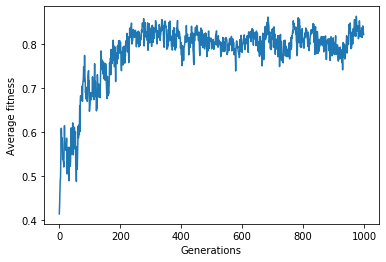

In [77]:
plt.plot(average_fitness)
plt.ylabel("Average fitness")
plt.xlabel("Generations")
#plt.savefig('ave_fit_wcost_f3.png')

Text(0.5, 0, 'Generations')

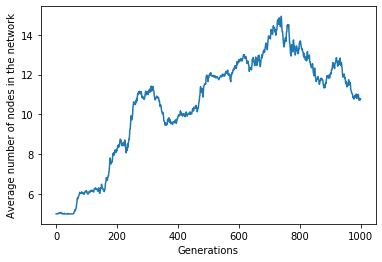

In [78]:
plt.plot(ave_grnsize)
plt.ylabel("Average number of nodes in the network")
plt.xlabel("Generations")
#plt.savefig('ave_size_wcost_f3.png')

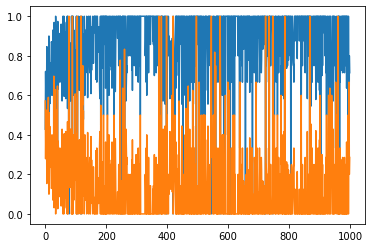

In [79]:
plt.plot(del_mut)
plt.plot(ben_mut)

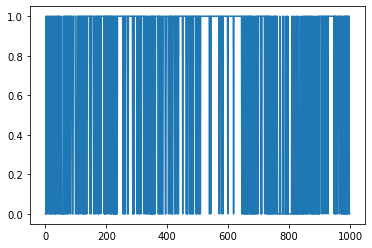

In [80]:
plt.plot(spec)